In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Orthogonality of our sponge circuit components to sRNA network

The circuit is composed of a synthetic sRNA and two fluorescent proteins mRNA's, cyRFP and EGFP.

## Imports

In [70]:
import os
import pandas as pd
import re
import logging 
import numpy as np

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.circuit.common.config_setup import retrieve_default_args, load_simulator_kwargs
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA, write_fasta_file
from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.type_handling import get_nth_elements, flatten_listlike

from subprocess import Popen, PIPE, run
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax

# jupyter nbconvert --to notebook --execute 18_orthogonality_extra_database.ipynb --output=18_orthogonality_extra_database_all.ipynb --ExecutePreprocessor.timeout=-1

# Load data

Load the sequences for EGFP and cyRFP, along with synthetic ChiX and the other sRNA's.

In [71]:
fn_tus = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_TUs_DH10B.csv')
fn_srnas = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_regulatory_RNAs_DH10B.csv')
fn_db = os.path.join('..', 'data', 'sRNA', 'TableS2_E_coli_with_seq.csv')
# fn_db = '../data/sRNA/TableS2_E_coli_with_seq.csv'
# fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
# fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
d_tus = pd.read_csv(fn_tus, index_col=0)
d_srnas = pd.read_csv(fn_srnas, index_col=0)
d_db = pd.read_csv(fn_db)
# d_merged = pd.read_csv(fn_merged, index_col=0)
# d_inter = pd.read_csv(fn_inter, index_col=0)

fn_fps = 'data/fps.fasta'
fn_muts = 'data/scott_mutations.fasta'
muts = load_seq_from_FASTA(fn_muts, as_type='dict')
fps = load_seq_from_FASTA(fn_fps, as_type='dict')

In [72]:
fps

{'EGFP': 'ACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAATACTAGAGAAAGAGGGGAAATACTAGTACCATATGCGTAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCAACATACGGAAAACTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCGGTTATGGTGTTCAATGCTTTGCGAGATACCCAGATCATATGAAACAGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAAAGAACTATATTTTTCAAAGATGACGGGAACTACAAGACACGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATAGAATCGAGTTAAAAGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAATTGGAATACAACTATAACTCACACAATGTATACATCATGGCAGACAAACAAAAGAATGGAATCAAAGTTAACTTCAAAATTAGACACAACATTGAAGATGGAAGCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCCACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGAGAGATCACATGGTCCTTCTTGAGTTTGTAACAGCTGCTGGGATTACACATGGCATGGATGAACTATACAAATAATCGACTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCC',
 'cyRFP1_Original': 'CATAGATTTGTAACTAAAAACAAGAAACTTATGGTATCAAAAGGTGAAGAGCTGATTAAAGAGAACATGAGATCAAAGCTTTAC

## Get new syntheses

In [73]:
sdirs = ['data/February 2024 synthesis', 'data/November 2024 synthesis']
all_synths = {}
all_overlaps = []
for sdir in sdirs:
    for f in os.listdir(sdir): 
        syn = load_seq_from_FASTA(os.path.join(sdir, f), as_type='dict')
        if any([k in all_synths for k in syn]):
            print(f'Warning: {f} has overlapping keys: {set(syn.keys()) & set(all_synths.keys())}')
            overlaps = set(syn.keys()) & set(all_synths.keys())
            for overlap in overlaps:
                all_overlaps.append(overlap)
                if not syn[overlap] == all_synths[overlap]:
                    name_new = overlap + f'_{all_overlaps.count(overlap)}'
                    print(f'Warning: {f} has different sequences for {overlap} - renaming to {name_new}')
        all_synths.update(syn)
        
all_synths

{'RiboJ_spRNA_mScarlet-I_alternative': 'AATGAGTCCAATAACGAACTTCGACATGATAAAGTCCCCCCCTCGCGACTTCCAGGGTCTCAGTACAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAtttattttaaattttccCGGTTCAAGGTGCACATGTTATTTCATaaatcaataccgcaatatttaaattgcggtttttaagggtatttttctCATAAGAGACCAGAAGAAGACTACTGAGTTGAGCGTTCCCAGCACTTCAGCCAAGGAAGTTACCAAT',
 'MicC': 'TCTACGCAGCGACATGTTTATTAACAGTTGTCTGGCAGCACAAAACTGGTCTCAGTACAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAACTCGAGAAAAAAAGCCCGGACGACTGTTCGGGCTTGTCTTTTTATATGTTGGAAAATCAGTGGCAATGCAATGGCCCAACAGAAAATGCGTAAAGGAGAAGAACTTTTCCATAAGAGACCTTTACCATGGTCGTAGAAGCCCCCCAGAGTTAGTTCATACCTAATGC',
 'ChiX_spRNA_MicC': 'AAAGGGCCTATATTTGCGGTCCAACTTAGGCGTAAACCTCGATGCTACCTACTCGGTCTCAGTACAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATATGCGTAAAGGAGAAGAACTTTTCGCCAATAGCGATATTGGCCATTTTTTTCATAAGAGACCAGACCCACCTCGCGCGGGGTAAATAAGGCACTCATCCCAGCTGGTTCTTGGCGT',
 'Syn-MgrR-mScarlet-

## Select sRNAs from database

In [74]:
to_remove = ['e14 prophage; ', 'Qin prophage; ', 'Rac prophage; ', 
             'putative antisense regulatory RNA ', 'small regulatory RNA antitoxin ', 
             'putative antitoxin ', 'antisense regulatory RNA ', 'small antisense RNA ',
             'antitoxin ', 'small regulatory RNA ', 'small RNA ', ' small regulatory RNA']

for r in to_remove:
    d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(r, '')
    
d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(' ', '_')
    

In [75]:
d_tus.loc[d_tus['Common-Name'].apply(lambda x: type(x) != str), 'Common-Name'] = d_tus.loc[d_tus['Common-Name'].apply(lambda x: type(x) != str), 'Accession-1']
dupes = d_tus['Common-Name'].value_counts()[d_tus['Common-Name'].value_counts() > 1].index.to_list()
d_tus.loc[d_tus['Common-Name'].isin(dupes), 'Common-Name'] = d_tus[d_tus['Common-Name'].isin(dupes)]['Accession-1']
print('Number of duplicates:', np.sum(d_tus['Common-Name'].value_counts()[d_tus['Common-Name'].value_counts() > 1]))

Number of duplicates: 0


In [76]:
srnas = dict(zip(d_srnas['Common-Name'].to_list(), d_srnas['Sequence - DNA sequence']))
mrnas = dict(zip(d_tus['Common-Name'].to_list(), d_tus['Sequence - DNA sequence']))

### Add sRNA's from the extra database Scott sent me (Nov 2024)

In [77]:
d_db['name'] = d_db['name'].str.replace('-<i>leuZ</i>', 'leuZ').apply(lambda x: x.split('_id-NC_000913.2')[0])
len(d_db), len(d_db['name'].unique())

(8175, 3781)

#### Make names and sequences unique

In [78]:
# Drop rows where the name and the sequence are duplicated
d_db.drop_duplicates(subset=['name', 'sequence'], keep='first', inplace=True)

# Make all names unique if there are repeating names
d_db['name'] = d_db['name'] + (d_db.groupby('name').cumcount()).astype(str).str.zfill(3).apply(lambda x: '_' + x).replace('_000', '')

# If a sequence is duplicated, combine the names and drop the rest
for s in d_db['sequence'].value_counts()[d_db['sequence'].value_counts() > 1].index:
    name_combined = ', '.join(sorted(d_db[d_db['sequence'] == s]['name'].values))
    d_db.loc[d_db[d_db['sequence'] == s].index[0], 'name'] = name_combined
    d_db.drop(d_db[d_db['sequence'] == s].index[1:], inplace=True)


In [79]:
overlaps_to_ignore = sorted(np.unique((d_db[d_db['sequence'].isin(srnas.values())]['name'].to_list())).tolist())
d_db_srna = d_db[(d_db['feature'] == 'sRNA') & (~d_db['name'].isin(overlaps_to_ignore))]
d_db_other = d_db[(d_db['feature'] != 'sRNA') & (~d_db['name'].isin(overlaps_to_ignore))]

srnas.update(dict(zip(d_db_srna['name'] + '_db', d_db_srna['sequence'])))
srnas_extradb = dict(zip(d_db_other['name'] + '_db', d_db_other['sequence']))
len(srnas), len(srnas_extradb)


(196, 7910)

In [80]:
all_synths

{'RiboJ_spRNA_mScarlet-I_alternative': 'AATGAGTCCAATAACGAACTTCGACATGATAAAGTCCCCCCCTCGCGACTTCCAGGGTCTCAGTACAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAtttattttaaattttccCGGTTCAAGGTGCACATGTTATTTCATaaatcaataccgcaatatttaaattgcggtttttaagggtatttttctCATAAGAGACCAGAAGAAGACTACTGAGTTGAGCGTTCCCAGCACTTCAGCCAAGGAAGTTACCAAT',
 'MicC': 'TCTACGCAGCGACATGTTTATTAACAGTTGTCTGGCAGCACAAAACTGGTCTCAGTACAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAACTCGAGAAAAAAAGCCCGGACGACTGTTCGGGCTTGTCTTTTTATATGTTGGAAAATCAGTGGCAATGCAATGGCCCAACAGAAAATGCGTAAAGGAGAAGAACTTTTCCATAAGAGACCTTTACCATGGTCGTAGAAGCCCCCCAGAGTTAGTTCATACCTAATGC',
 'ChiX_spRNA_MicC': 'AAAGGGCCTATATTTGCGGTCCAACTTAGGCGTAAACCTCGATGCTACCTACTCGGTCTCAGTACAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATATGCGTAAAGGAGAAGAACTTTTCGCCAATAGCGATATTGGCCATTTTTTTCATAAGAGACCAGACCCACCTCGCGCGGGGTAAATAAGGCACTCATCCCAGCTGGTTCTTGGCGT',
 'Syn-MgrR-mScarlet-

#### Add SynChiX to srnas

In [81]:
synchix = {'Syn_ChiX_20D_old': muts['Syn_ChiX_20-D']}
synchix.update({k: v for k, v in all_synths.items() if 'Syn_ChiX_20D' in k})
srnas.update(synchix)
synchix


{'Syn_ChiX_20D_old': 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT',
 'Syn_ChiX_20D': 'CCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTTTCGACTCGGTACCAAATTTTCGAAAAAAGACGCTGAAAAGCGTCTTTTTTCGTTTTGGTCC',
 'Syn_ChiX_20D_RiboJRemoved': 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTTTCGACTCGGTACCAAATTTTCGAAAAAAGACGCTGAAAAGCGTCTTTTTTCGTTTTGGTCC',
 'Syn_ChiX_20D_NewRiboJ': 'ACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTTTCGACTCGGTACCAAATTTTCGAAAAAAGACGCTGAAAAGCGTCTTTTTTCGTTTTGGTCC'}

## Download genome if needed

In [82]:
download_genomes = False

accessions = ["NC_010473.1", d_db['seqID'].iloc[0]]

for accession in accessions:
    output_file = f"data/18_orthogonality_extra_database/genome_{accession.replace('.', '_')}.fasta"
    if os.path.exists(output_file):
        print(f'Found file for genome {accession}')
    else:
        print(f'No file found for genome {accession}')
    if download_genomes:
        from Bio import SeqIO
        from Bio import Entrez
        
        def download_genomes(accession):
            Entrez.email = "olivia.gallup@gmail.com"  # Add your email address
            Entrez.api_key = "8167226cf01abaa985a1c23d9b5283d22208"  # Add your NCBI API key
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
            record = SeqIO.read(handle, "fasta")
            handle.close()
            return record
        

        genome_record = download_genomes(accession)
        SeqIO.write(genome_record, output_file, "fasta")
        print(f"Genome saved as {output_file}")
    

No file found for genome NC_010473.1
No file found for genome NC_000913.2


In [83]:

# genome_fasta = load_seq_from_FASTA(output_file, as_type='dict')

# genome_fasta['NC_010473.1']
# sliding_window = 300  # bp
# overlap = 100
# genome_fasta_split = {}
# for i in range(0, len(genome_fasta['NC_010473.1']), sliding_window):
#     j = int(max([i + sliding_window + overlap, len(genome_fasta['NC_010473.1'])]))
#     genome_fasta_split[f'{i}:{j}'] = genome_fasta['NC_010473.1'][i:j]
# write_fasta_file(out_path=output_file, data=genome_fasta_split, byseq=True)


# Run IntaRNA

May need to put all the sRNA's into one fasta.

In [84]:
top_dir = 'data/18_orthogonality_extra_database'

fasta_synths = os.path.join(top_dir, 'synths.fasta')
fasta_srnas = os.path.join(top_dir, 'srnas.fasta')
fasta_srnas_extradb = os.path.join(top_dir, 'srnas_extradb.fasta')
fasta_mrnas = os.path.join(top_dir, 'mrnas.fasta')
fasta_fps = os.path.join(top_dir, 'fps.fasta')
fasta_synchix = os.path.join(top_dir, 'synchix.fasta')

write_fasta_file(out_path=fasta_synths, data=all_synths, byseq=True)
write_fasta_file(out_path=fasta_srnas, data=srnas, byseq=True)
write_fasta_file(out_path=fasta_srnas_extradb, data=srnas_extradb, byseq=True)
write_fasta_file(out_path=fasta_mrnas, data=mrnas, byseq=True)
write_fasta_file(out_path=fasta_fps, data=fps, byseq=True)
write_fasta_file(out_path=fasta_synchix, data=synchix, byseq=True)

In [85]:
synchix

{'Syn_ChiX_20D_old': 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT',
 'Syn_ChiX_20D': 'CCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTTTCGACTCGGTACCAAATTTTCGAAAAAAGACGCTGAAAAGCGTCTTTTTTCGTTTTGGTCC',
 'Syn_ChiX_20D_RiboJRemoved': 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTTTCGACTCGGTACCAAATTTTCGAAAAAAGACGCTGAAAAGCGTCTTTTTTCGTTTTGGTCC',
 'Syn_ChiX_20D_NewRiboJ': 'ACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTTTCGACTCGGTACCAAATTTTCGAAAAAAGACGCTGAAAAGCGTCTTTTTTCGTTTTGGTCC'}

In [86]:
# jupyter nbconvert --to notebook --execute 18_orthogonality_extra_database.ipynb --output=18_orthogonality_extra_database1.ipynb --ExecutePreprocessor.timeout=-1

run_intarna = False

config = {
    "experiment": {
        "purpose": "tests",
    },
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
                "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
                "threads": 6,
                "n": 1,
                "raw_stdout": True
        }
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

    os.rmdir(data_writer.top_write_dir)
    data_writer.top_write_dir = top_dir
    data_writer.reset_ensemble()
    data_writer.unsubdivide()

In [87]:
def simulate_IntaRNA_local(fn_query: str,
                           fn_targets: str,
                           sim_kwargs={}):
    sim_kwargs['query'] = fn_query
    sim_kwargs['target'] = fn_targets

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


if run_intarna:

    # sRNA's vs FPs + synChiX
    run_srnas_vs_fps = False
    if run_srnas_vs_fps:
        sim_data = simulate_IntaRNA_local(fn_query=fasta_fps,
                                          fn_targets=fasta_srnas,
                                          sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

        data_writer.output(data=sim_data, out_type='json',
                           out_name='inter_data_raw', overwrite=True)

    # sRNA's from extra db vs FPS + SynChiX
    run_srnas_extra_vs_fps = False
    if run_srnas_extra_vs_fps:
        sim_data_extradb = simulate_IntaRNA_local(fn_query=fasta_fps,
                                                  fn_targets=fasta_srnas_extradb,
                                                  sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

        data_writer.output(data=sim_data_extradb, out_type='json',
                           out_name='inter_data_extradb', overwrite=True)

    # Spot probabilities / Position-wise minimal energy profile
    run_spot = True
    if run_spot:
        config_spot = config['interaction_simulator']['simulator_kwargs']
        config_spot.update({'extra_params': [
                           f'--out=qSpotProb:{os.path.join(top_dir, "fps_spot", "fps_spot.csv")}']})
        sim_data_spot = simulate_IntaRNA_local(
            fn_query=fasta_fps, fn_targets=fasta_srnas, sim_kwargs=config_spot)
        data_writer.output(data=sim_data_spot, out_type='json',
                           out_name='inter_data_spot', overwrite=True)
        config_spot.update({'extra_params': [
                           f'--out=qSpotProb:{os.path.join(top_dir, "fps_extras_spot", "fps_extras_spot.csv")}', '--seedBP=2']})
        sim_data_spotextra = simulate_IntaRNA_local(
            fn_query=fasta_fps, fn_targets=fasta_srnas_extradb, sim_kwargs=config_spot)
        data_writer.output(data=sim_data_spotextra, out_type='json',
                           out_name='inter_data_spotextra', overwrite=True)

    # sRNAs_extradb vs. SynChiX
    run_extra_vs_synchix = False
    if run_extra_vs_synchix:
        sim_data_extrasynchix = simulate_IntaRNA_local(fn_query=fasta_synchix,
                                                       fn_targets=fasta_srnas_extradb,
                                                       sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

        data_writer.output(data=sim_data_extrasynchix, out_type='json',
                           out_name='inter_data_extrasynchix', overwrite=True)

    # sRNA's vs muts
    run_srnas_vs_muts = False
    if run_srnas_vs_muts:
        sim_data_muts = simulate_IntaRNA_local(fn_query=fn_muts,
                                               fn_targets=fasta_srnas,
                                               sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

        data_writer.output(data=sim_data_muts, out_type='json',
                           out_name='inter_data_muts', overwrite=True)

    # sRNA's vs muts from extra db
    run_srnas_vs_mutextradb = False
    if run_srnas_vs_mutextradb:
        sim_data_mutextradb = simulate_IntaRNA_local(fn_query=fn_muts,
                                                     fn_targets=fasta_srnas_extradb,
                                                     sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

        data_writer.output(data=sim_data_mutextradb, out_type='json',
                           out_name='inter_data_mutextradb', overwrite=True)

    # mRNA screen
    run_synths_vs_mrnas = False
    if run_synths_vs_mrnas:
        config['interaction_simulator']['simulator_kwargs']['n'] = 2
        n_splits = 100
        sim_data_mrna = {}
        # for n in range(0, len(mrnas), n_splits):
        #     mrnas_subset = mrnas
        write_fasta_file(out_path=fasta_mrnas, data=mrnas, byseq=True)
        sim_data_mrna.update(simulate_IntaRNA_local(fn_query=fasta_synths,
                                                    fn_targets=fasta_mrnas,
                                                    sim_kwargs=config['interaction_simulator']['simulator_kwargs']))
        data_writer.output(data=sim_data_mrna, out_type='json',
                           out_name='inter_data_mrnas', overwrite=True)
        print(data_writer.write_dir)

    # Genome screen
    # run_genome_screen = False
    # if run_genome_screen:
    #     sim_data_genome = simulate_IntaRNA_local(fn_query=fn_muts,
    #                                            fn_targets=fasta_srnas,
    #                                            sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

    #     data_writer.output(data=sim_data_genome, out_type='json',
    #                        out_name='inter_data_genome', overwrite=True)

## Load back in

In [88]:
sim_data_l = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_raw.json')
sim_data_l_extradb = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_extradb.json')
sim_data_l_extrasynchix = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_extrasynchix.json')
sim_data_l_muts = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_muts.json')
sim_data_l_mutextradb = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_mutextradb.json')
sim_data_l_geno = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_mrnas.json')

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': '', 'subseqDB': '', 'Pu1': 0.0, 'Pu2': 0.0
}
# for isim_data_l, iquery in zip([sim_data_l, sim_data_l_extradb, sim_data_l_extrasynchix, sim_data_l_muts], [fps, fps, synchix, muts]):
for isim_data_l, iquery in zip([sim_data_l, sim_data_l_extradb, sim_data_l_extrasynchix, sim_data_l_muts, sim_data_l_geno], [fps, fps, synchix, muts, all_synths]):
    for s, v in isim_data_l.items():            
        if len(v.values()) < len(iquery):
            diffs = set(iquery.keys()) - set(v.keys())
            for d in diffs:
                isim_data_l[s][d] = default_vals

# Visualise

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cool_color = "#3b4cc0"  # Example cool color (blue-ish)
center_color_l = "#eaeaea"  # Example neutral center color (white)
center_color_d = "#1a1a1a"  # Example neutral center color (white)
warm_color = "#ff003c"  # Example warm color (red-ish)

def make_diverging(x, center=1, cool_color=cool_color, center_color=center_color_l, warm_color=warm_color):
    colors = [(0, cool_color), (center/(np.max(x) - np.min(x)), center_color), (1, warm_color)]
    return LinearSegmentedColormap.from_list("custom_cmap", colors)
    

cols_cyrfp = [k for k in fps.keys() if 'cyrfp' in k.lower()]
cols_fps = list(fps.keys())

Text(0.5, 0.98, 'sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

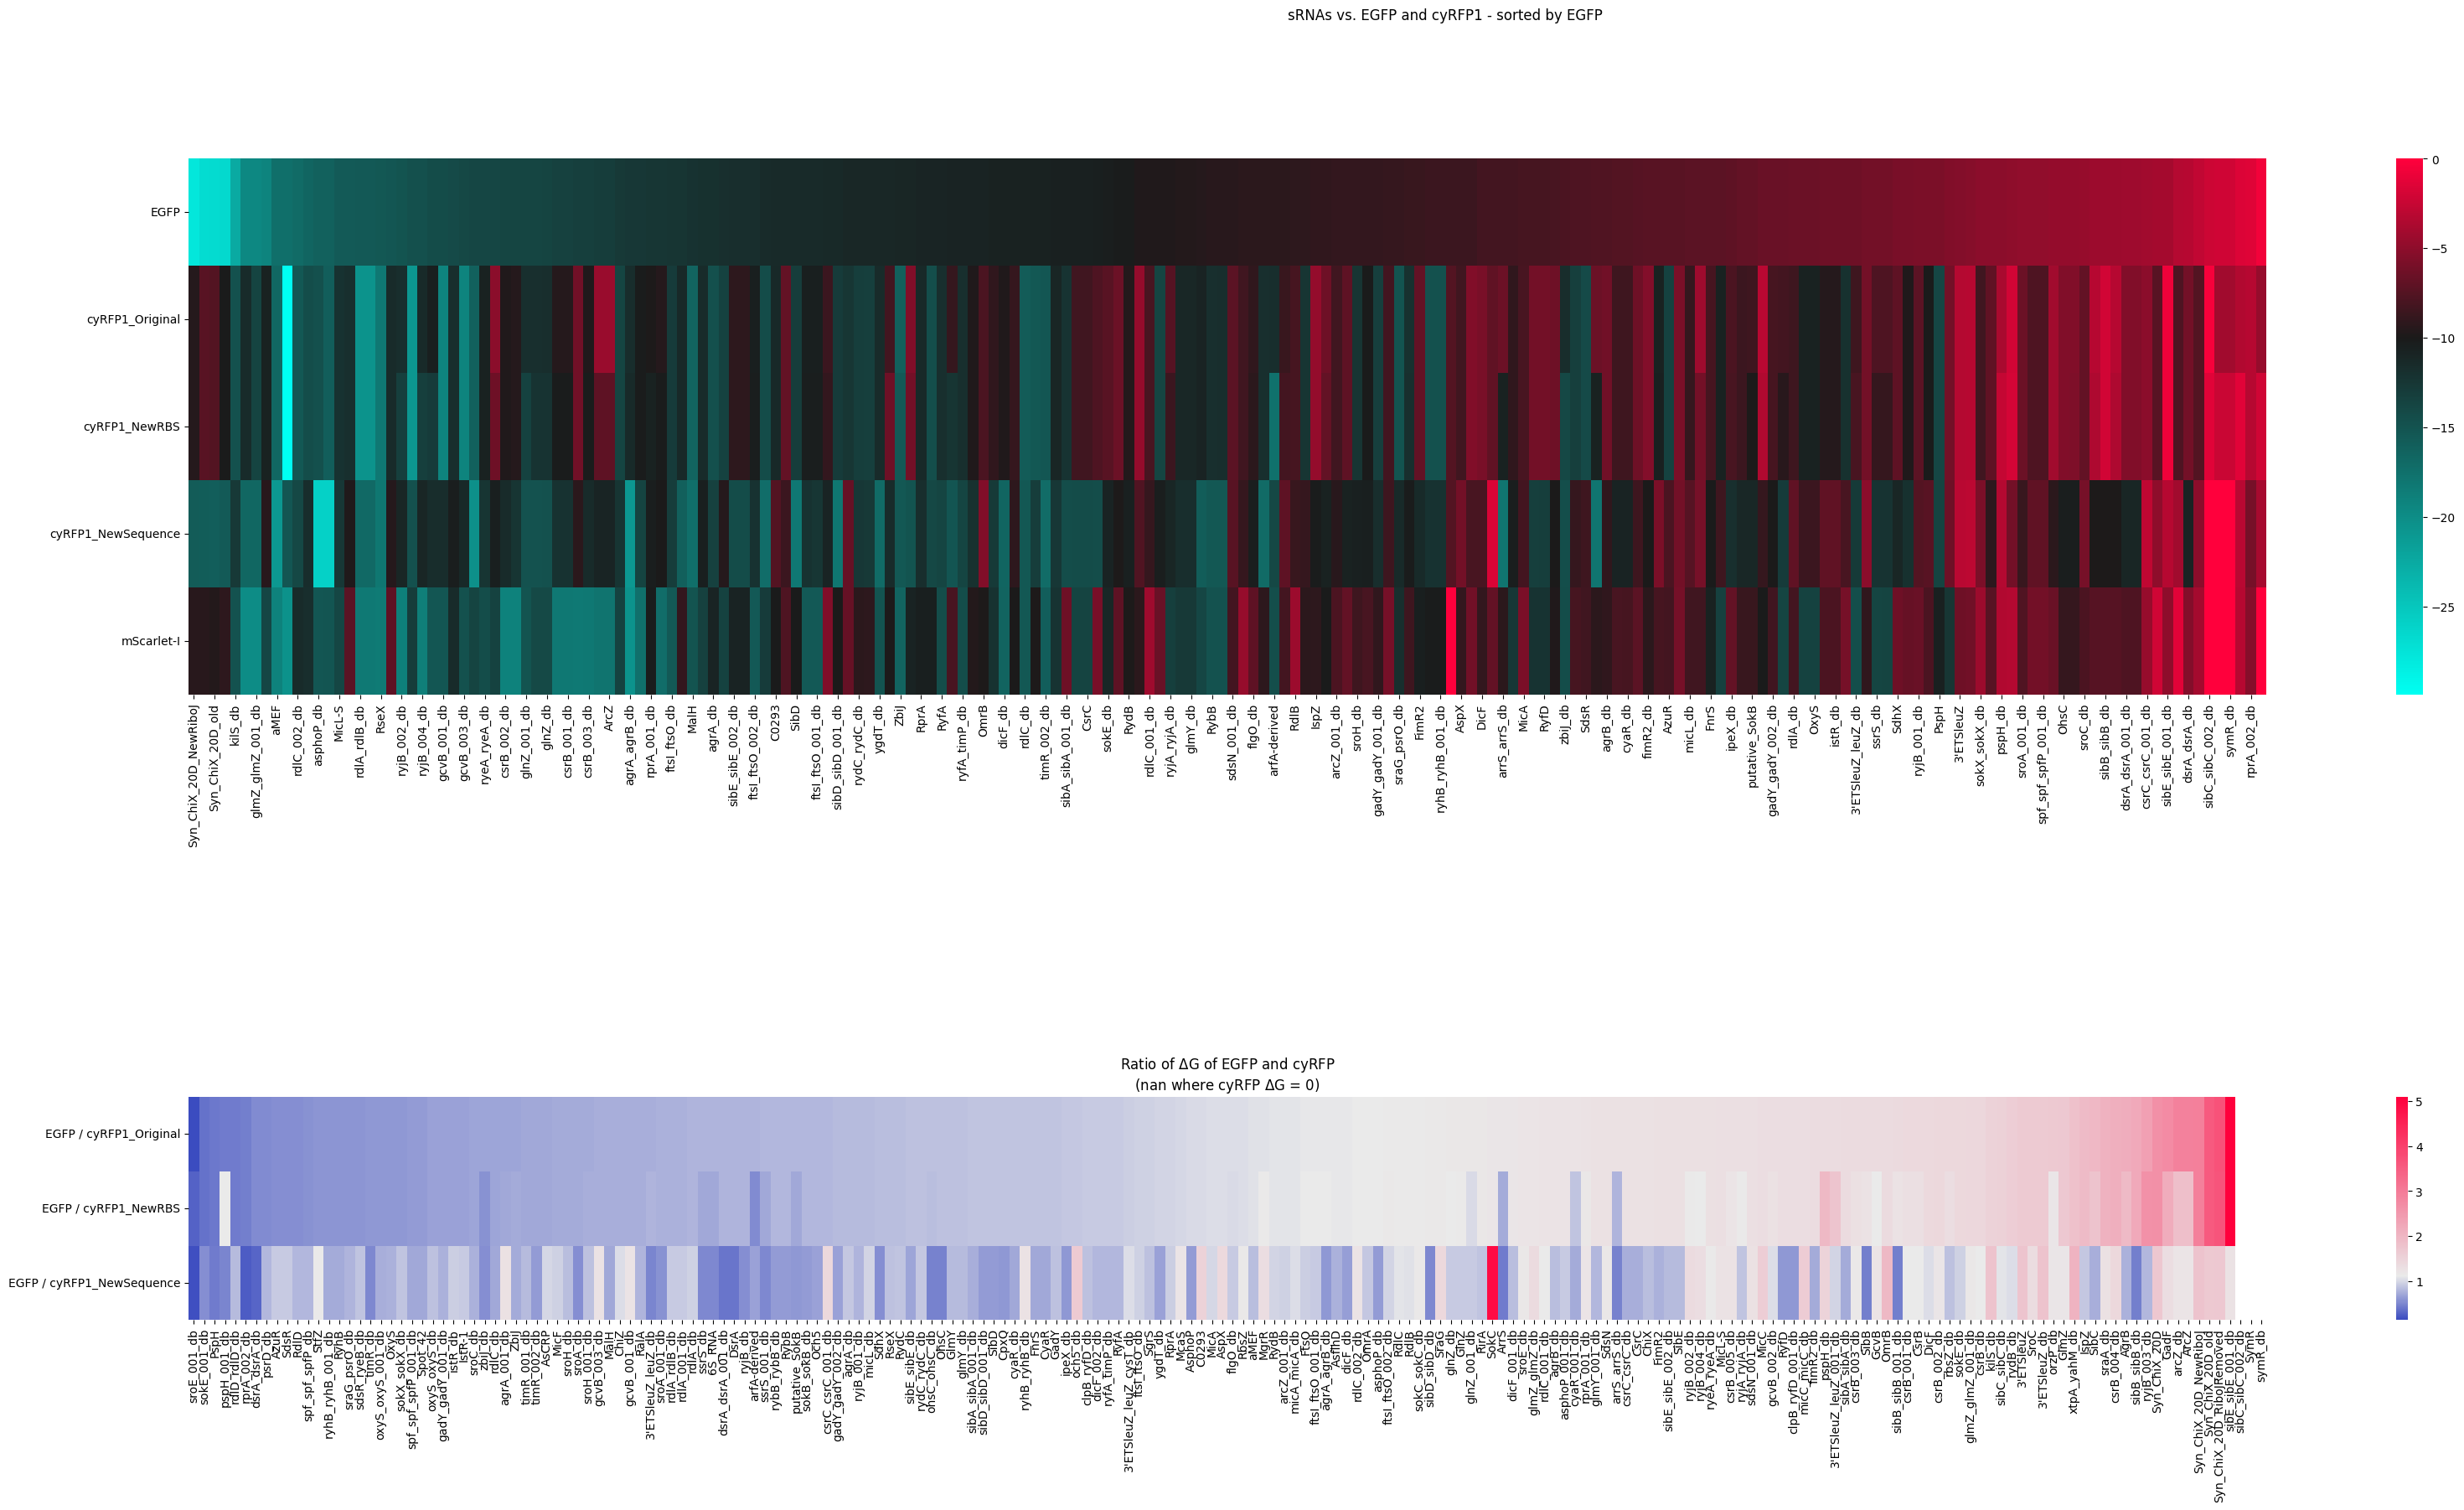

In [90]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
energies = energies.sort_index(key=lambda x: x.str.lower())[sorted(energies.columns, key=lambda x: x.lower())]
energies = energies.T

fig = plt.figure(figsize=(40, 2*9))
fig.subplots_adjust(hspace=0.4)
# ax = plt.subplot(2,1,1)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
custom_cmap = make_diverging(-energies[list(cols_fps)], center=np.max(-energies[list(cols_fps)]) - 10, 
                             center_color=center_color_d, cool_color='#00fff2')
sns.heatmap(energies.sort_values('EGFP')[list(cols_fps)].T, ax=ax1, cmap=custom_cmap)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

# ax = plt.subplot(2,1,2)
cols_cyrfp_ratios = [f'EGFP / {k}' for k in cols_cyrfp] 
for k, kr in zip(cols_cyrfp, cols_cyrfp_ratios):
    energies[kr] = energies['EGFP'] / energies[k]
    energies[energies[kr] < -300] = np.nan
energies = energies.sort_values(cols_cyrfp_ratios[0])
custom_cmap = make_diverging(energies[cols_cyrfp_ratios], center=1)
sns.heatmap(energies[[f'EGFP / {k}' for k in cols_cyrfp]].T, yticklabels=[f'EGFP / {k}' for k in cols_cyrfp], xticklabels=energies.index.to_list(), 
            ax=ax2, # center=1, 
            cmap=custom_cmap)
plt.title('Ratio of $\Delta$G of EGFP and cyRFP\n(nan where cyRFP $\Delta$G = 0)')

plt.suptitle('sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

# energies = energies.drop(labels='MicC')
# ax = plt.subplot(2,1,2)
# sns.heatmap(energies)
# plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\n(without construct MicC)')


Text(0.5, 0.98, 'sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

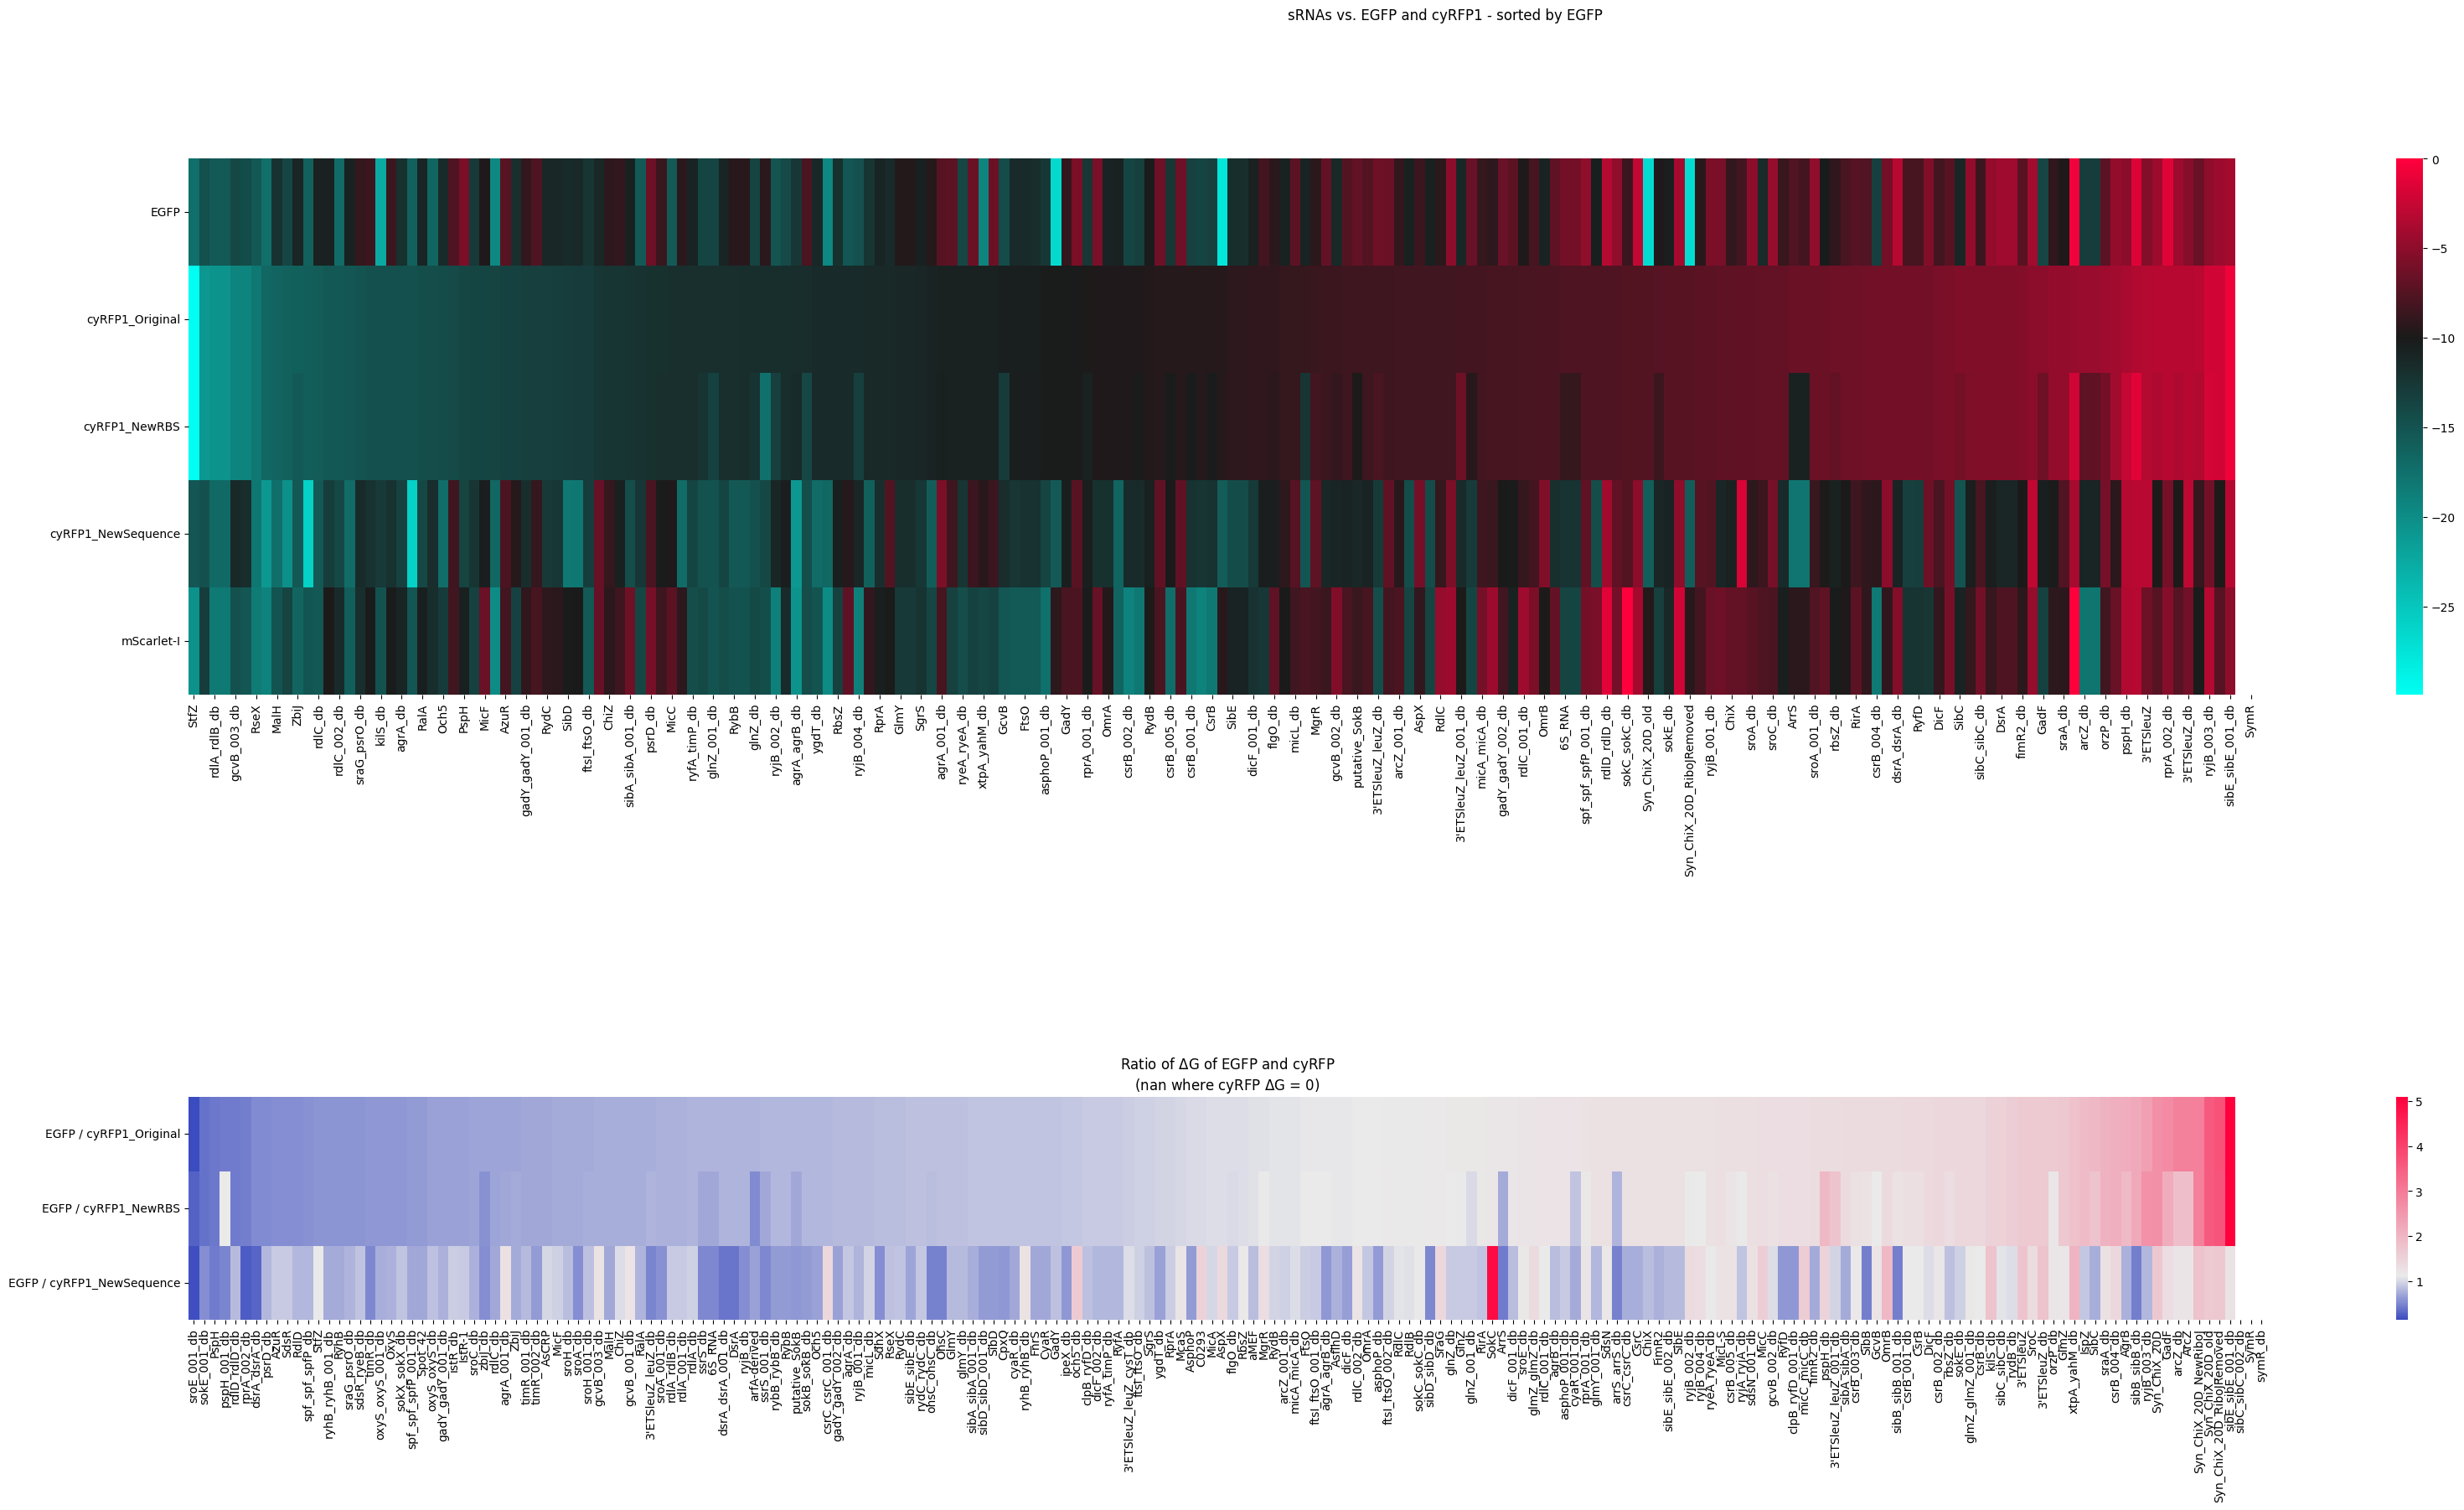

In [91]:
fig = plt.figure(figsize=(40, 2*9))
fig.subplots_adjust(hspace=0.4)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
custom_cmap = make_diverging(-energies[list(cols_fps)], center=np.max(-energies[list(cols_fps)]) - 10, 
                             center_color=center_color_d, cool_color='#00fff2')
sns.heatmap(energies.sort_values('cyRFP1_Original')[list(cols_fps)].T, ax=ax1, cmap=custom_cmap)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

custom_cmap = make_diverging(energies[cols_cyrfp_ratios], center=1)
sns.heatmap(energies.sort_values(cols_cyrfp_ratios[0])[[f'EGFP / {k}' for k in cols_cyrfp]].T, yticklabels=[f'EGFP / {k}' for k in cols_cyrfp], xticklabels=energies.index.to_list(), 
            ax=ax2, # center=1, 
            cmap=custom_cmap)
plt.title('Ratio of $\Delta$G of EGFP and cyRFP\n(nan where cyRFP $\Delta$G = 0)')

plt.suptitle('sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

Text(0.5, 1.0, 'Difference (absolute) from EGFP to cyRFP $\\Delta$G')

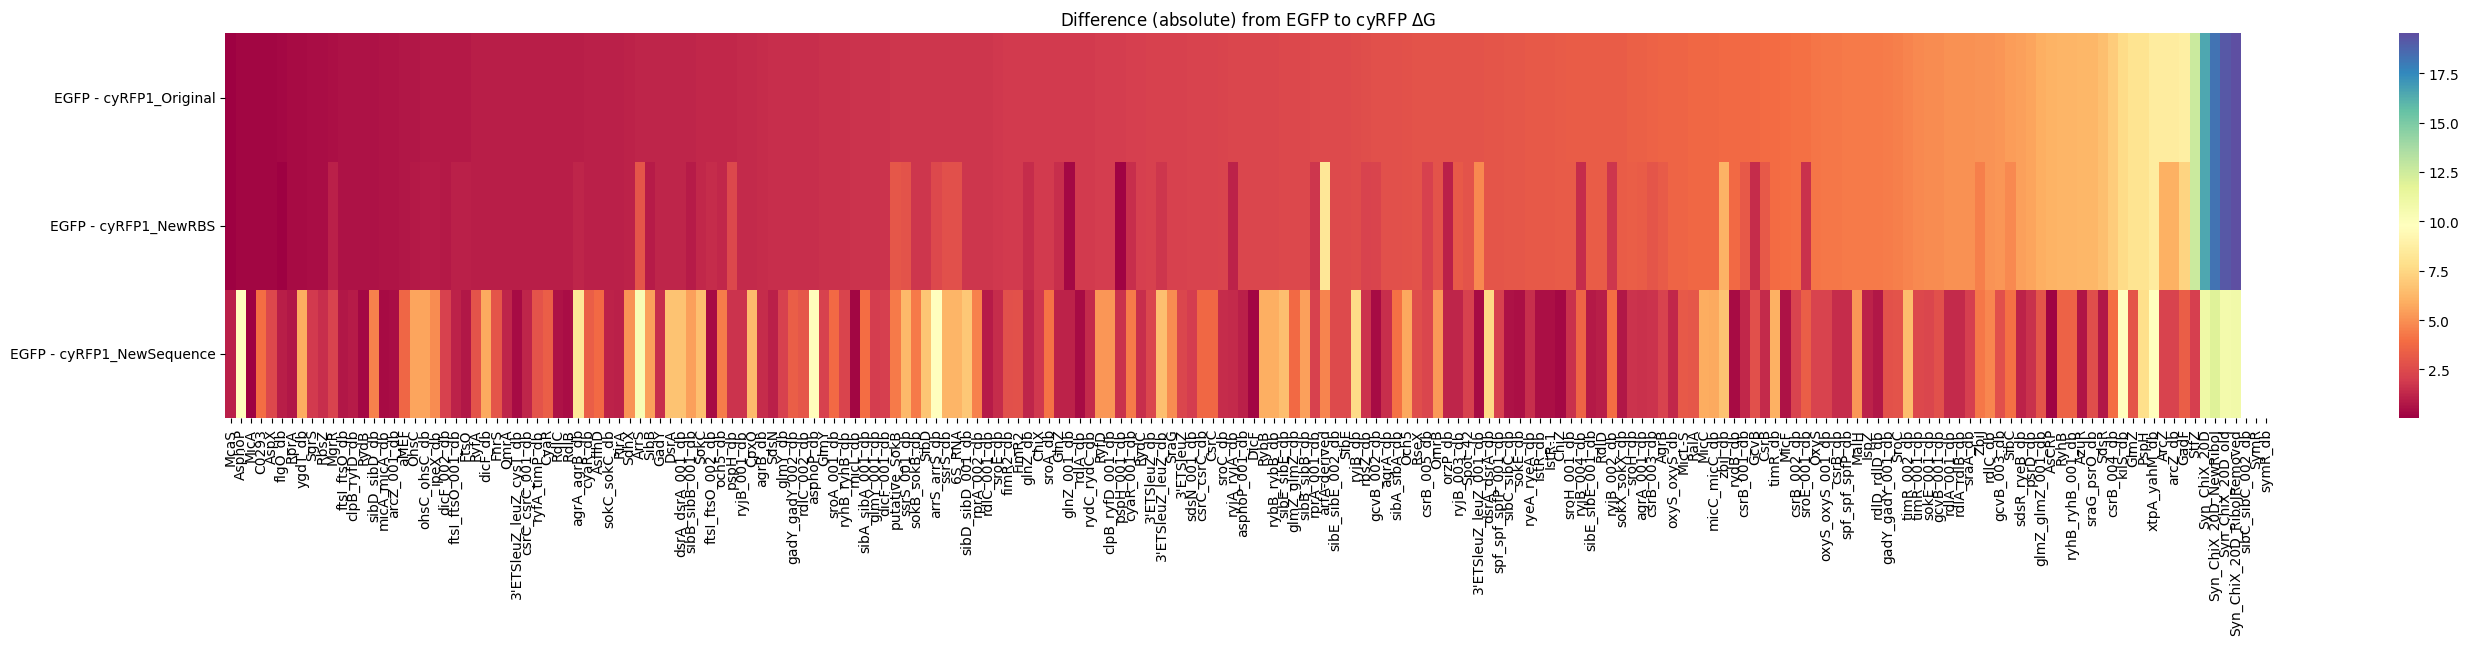

In [92]:
fig = plt.figure(figsize=(33, 5))
cols_cyrfp_diffs = [f'EGFP - {k}' for k in cols_cyrfp]
for k, kd in zip(cols_cyrfp, cols_cyrfp_diffs):
    energies[kd] = np.abs(energies['EGFP'] - energies[k])
energies = energies.sort_values(cols_cyrfp_diffs[0])
sns.heatmap(energies[cols_cyrfp_diffs].T, yticklabels=cols_cyrfp_diffs, xticklabels=energies.index.to_list(), cmap='Spectral')
plt.title('Difference (absolute) from EGFP to cyRFP $\Delta$G')

Text(0.5, 1.0, 'Ratio from new to old cyRFP $\\Delta$G')

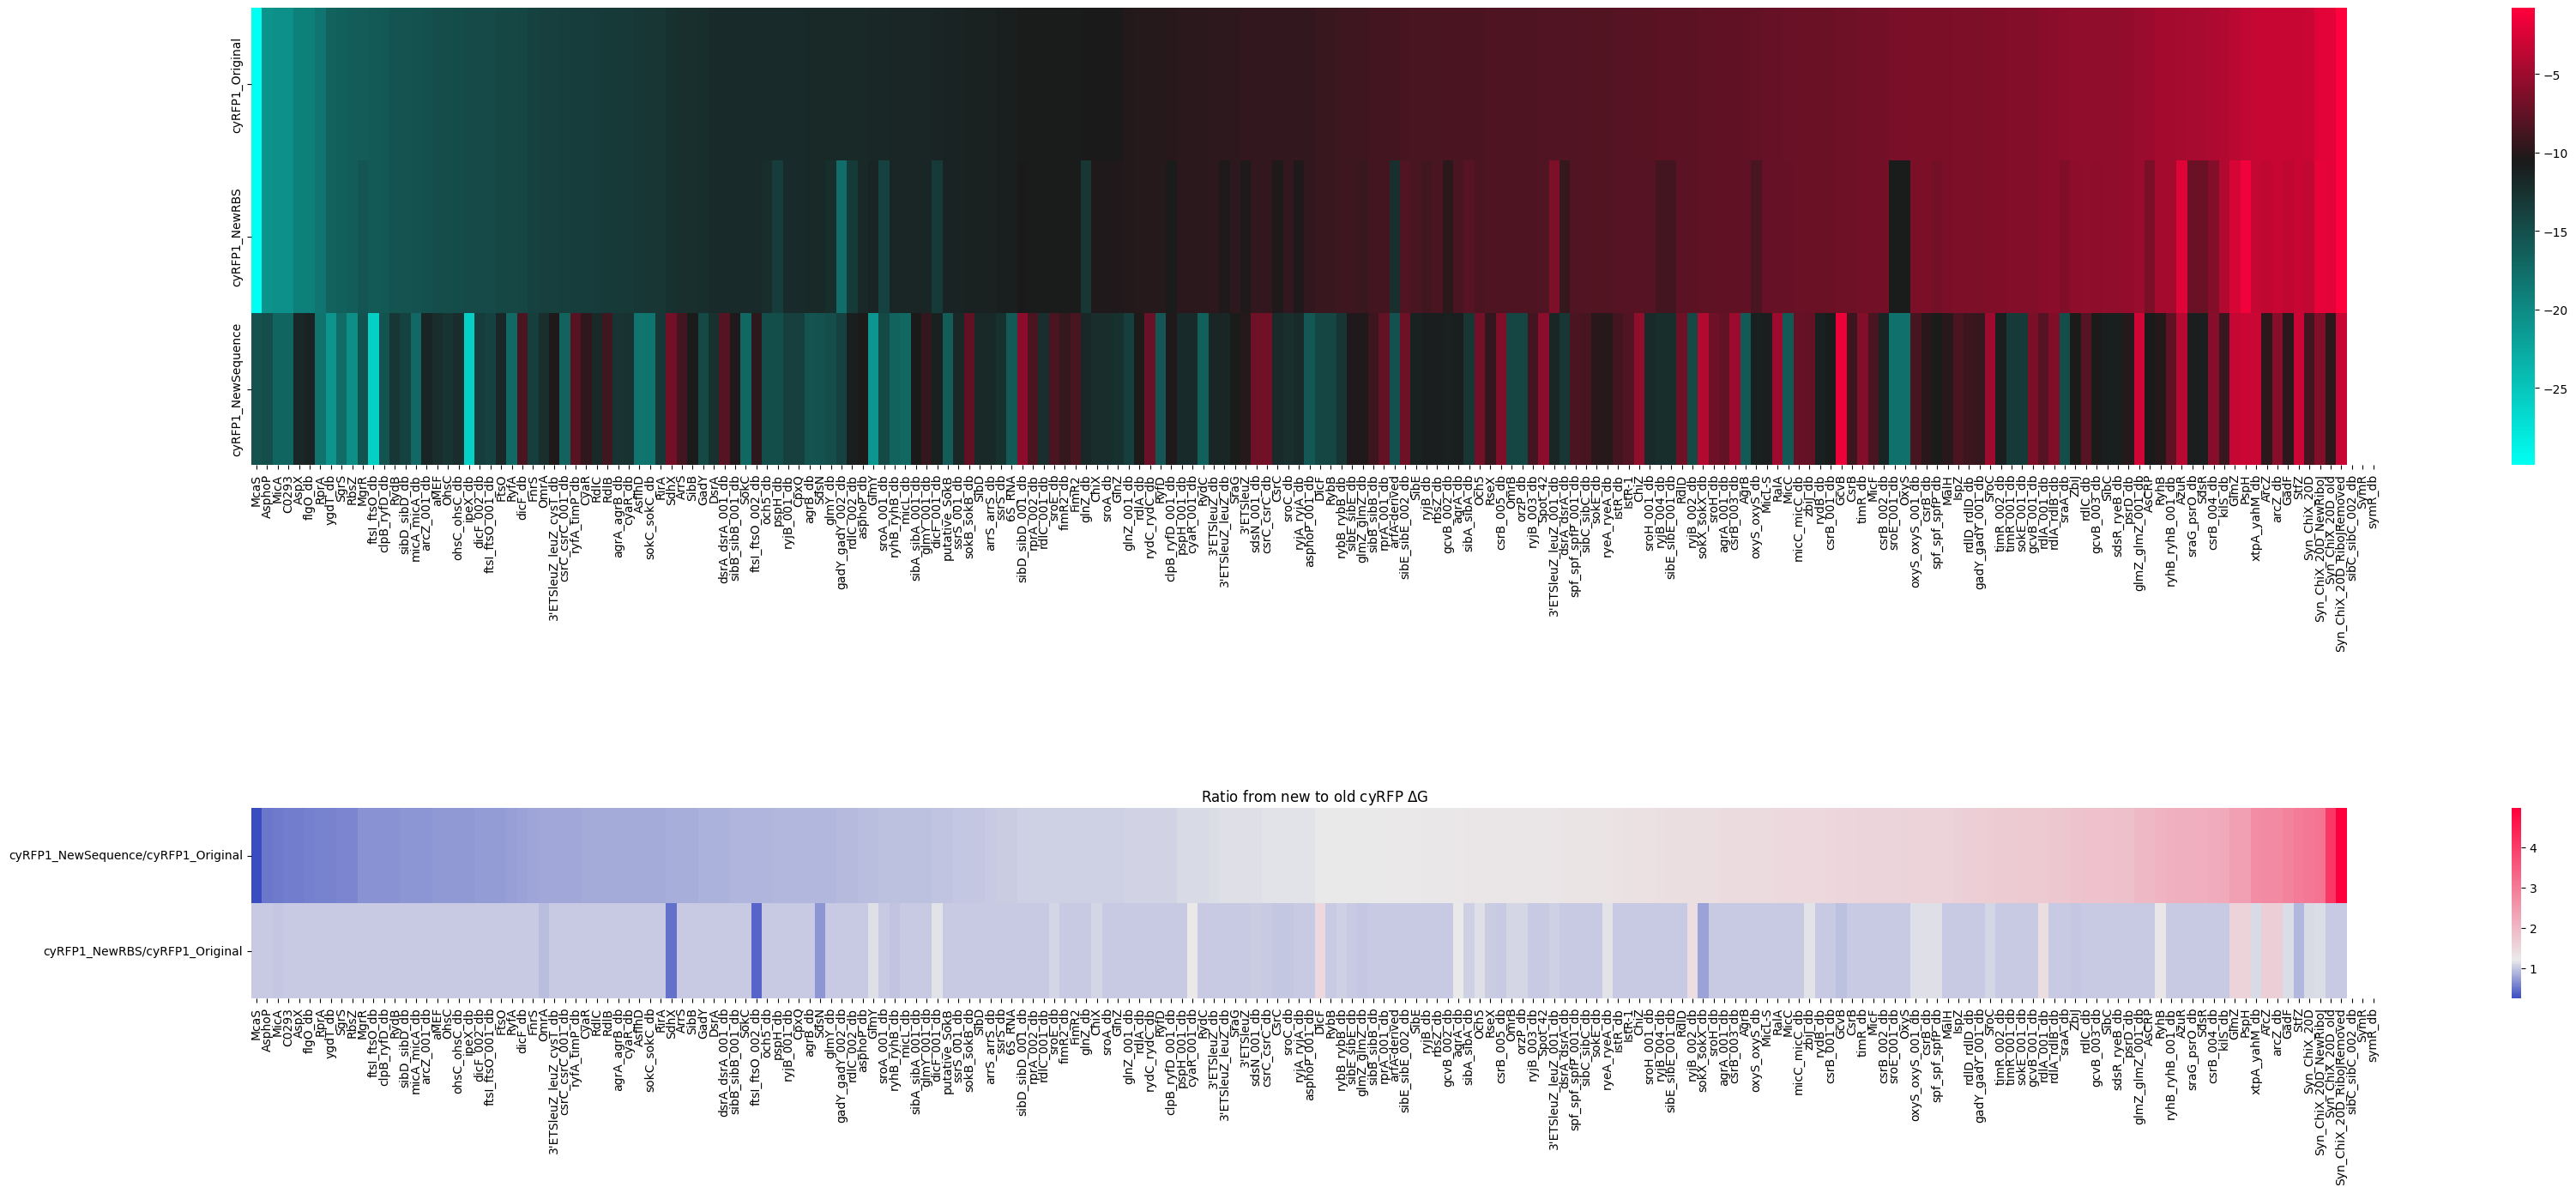

In [93]:
fig = plt.figure(figsize=(40, 5*len(cols_cyrfp)))
fig.subplots_adjust(hspace=0.4)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
custom_cmap = make_diverging(-energies[cols_cyrfp], center=np.max(-energies[cols_cyrfp]) - 10, 
                            #  center_color=center_color_d, cool_color='#5f00ff', warm_color='#ffe3aa')
                             center_color=center_color_d, cool_color='#00fff2')
sns.heatmap(energies.sort_values(by=cols_cyrfp[0])[cols_cyrfp].T, xticklabels=energies.index.to_list(), cmap=custom_cmap, # cmap='Spectral',
            ax=ax1)
plt.title('Difference between new and old cyRFP1 $\Delta$G')

cols_cyrfp_newold = [f'{k}/cyRFP1_Original' for k in ['cyRFP1_NewSequence', 'cyRFP1_NewRBS']]
for k, kd in zip(['cyRFP1_NewSequence', 'cyRFP1_NewRBS'], cols_cyrfp_newold):
    energies[kd] = energies[k] / energies['cyRFP1_Original']
custom_cmap = make_diverging(energies[cols_cyrfp_newold], center=1)
sns.heatmap(energies.sort_values(by=cols_cyrfp_newold[0])[cols_cyrfp_newold].T, yticklabels=cols_cyrfp_newold, xticklabels=energies.index.to_list(), cmap=custom_cmap,
            ax=ax2)
plt.title('Ratio from new to old cyRFP $\Delta$G')

#### Binding positions on new and old cyRFPs

In [94]:
binding_pos = {}
for fp in cols_fps:
    binding_pos[fp] = np.array([np.array(list(v[fp]['hybridDPfull'].split('&')[1])) == ')' if v[fp]['E'] else np.zeros(len(fps[fp]), dtype=bool) for v in sim_data_l.values()])
    binding_pos[fp] = pd.DataFrame(data=binding_pos[fp].T, columns=sim_data_l.keys()).T
                        # columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
    

In [95]:
fps_spot = {}
for j in range(len(cols_fps)):
    for i, s in enumerate(srnas.keys()):
        r = pd.read_csv(os.path.join(top_dir, 'fps_spot', f'fps_spot-t{i+1}q{j+1}.csv'), delimiter=';')
        if s not in fps_spot.get(cols_fps[j], r).columns:
            fps_spot[cols_fps[j]] = pd.concat([fps_spot.get(cols_fps[j], r), r.rename(columns={'spotProb': s})[s]], axis=1)
        else:
            print(f'{s} would have been duplicated')
    # fps_spot[cols_fps[j]] = fps_spot[cols_fps[j]].T.drop_duplicates().T

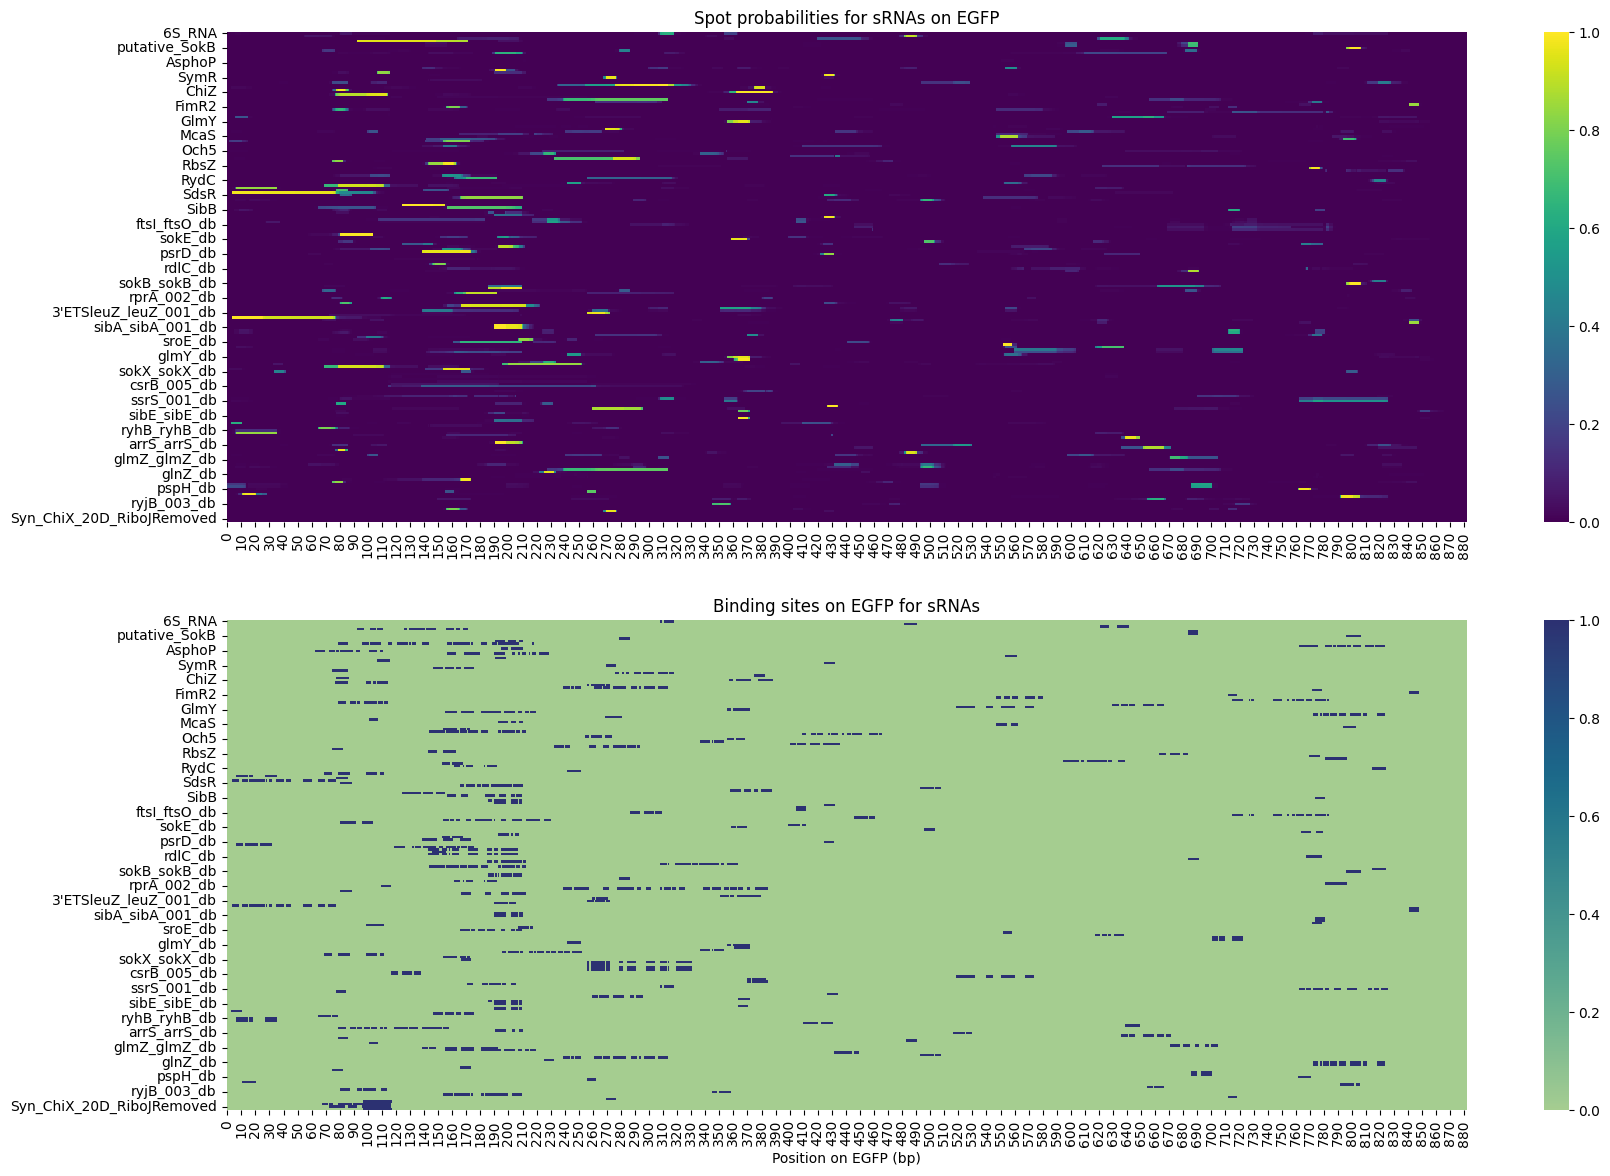

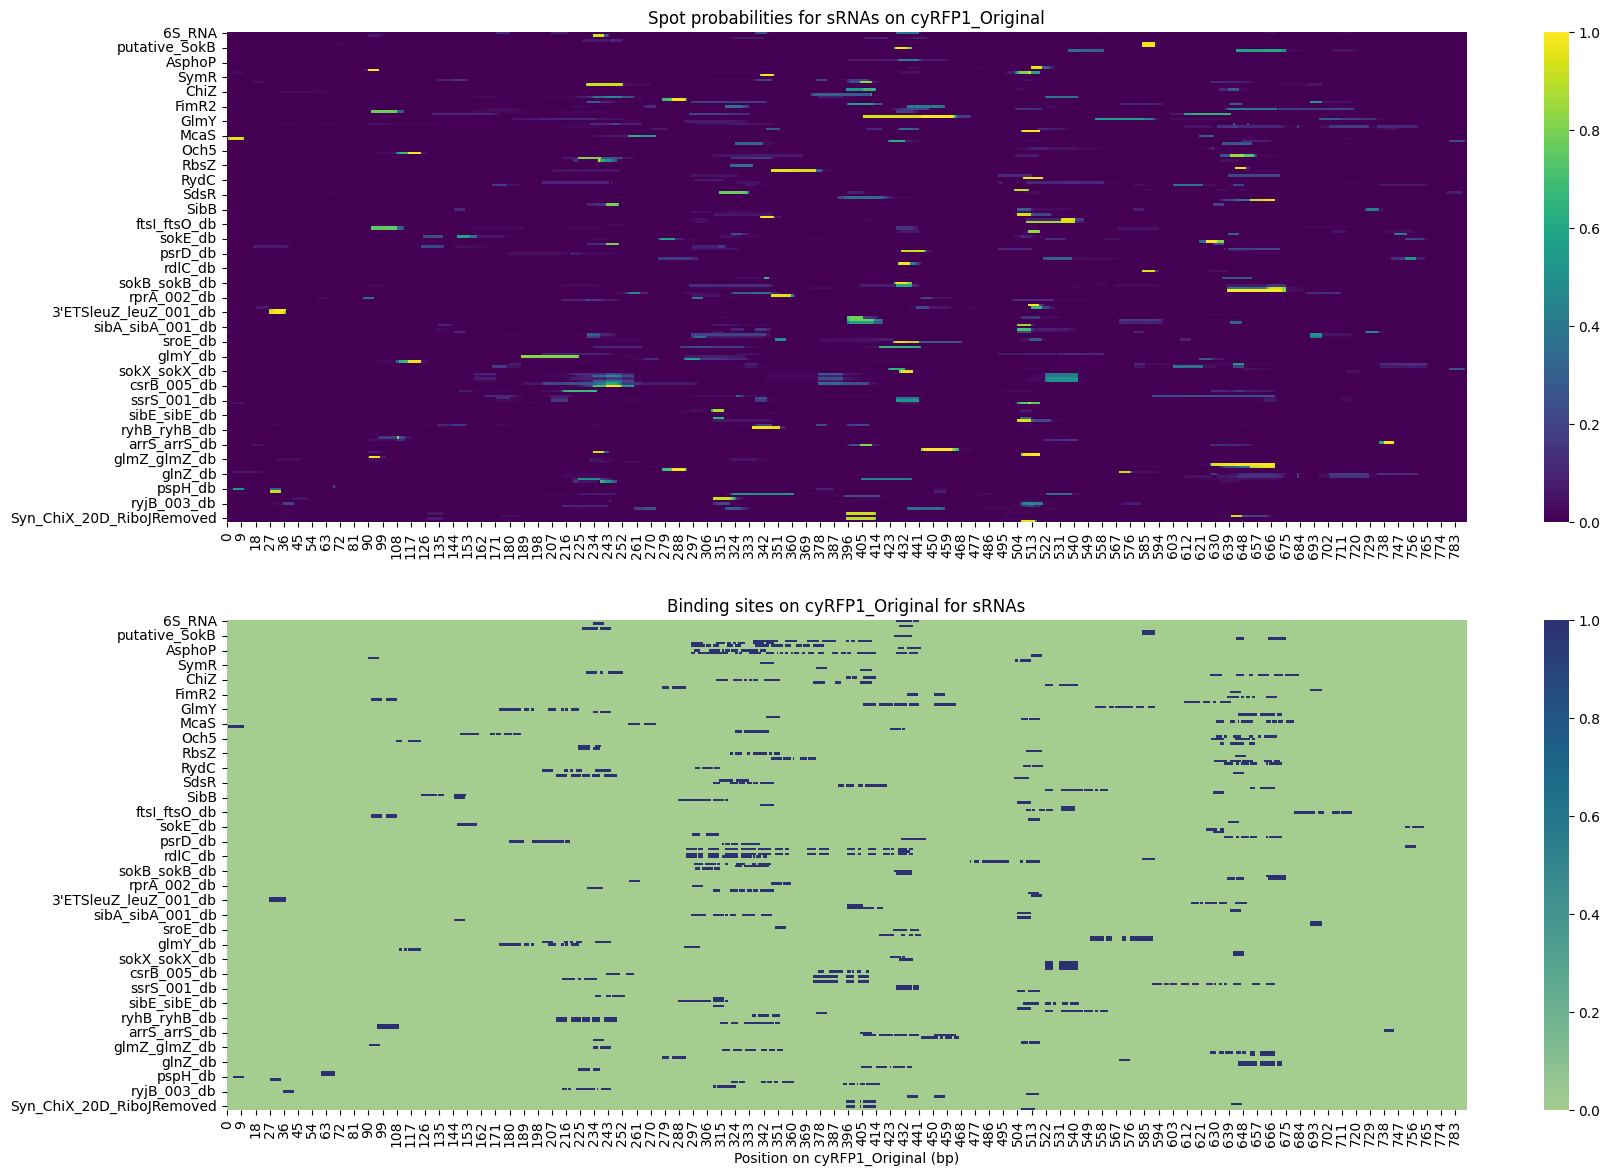

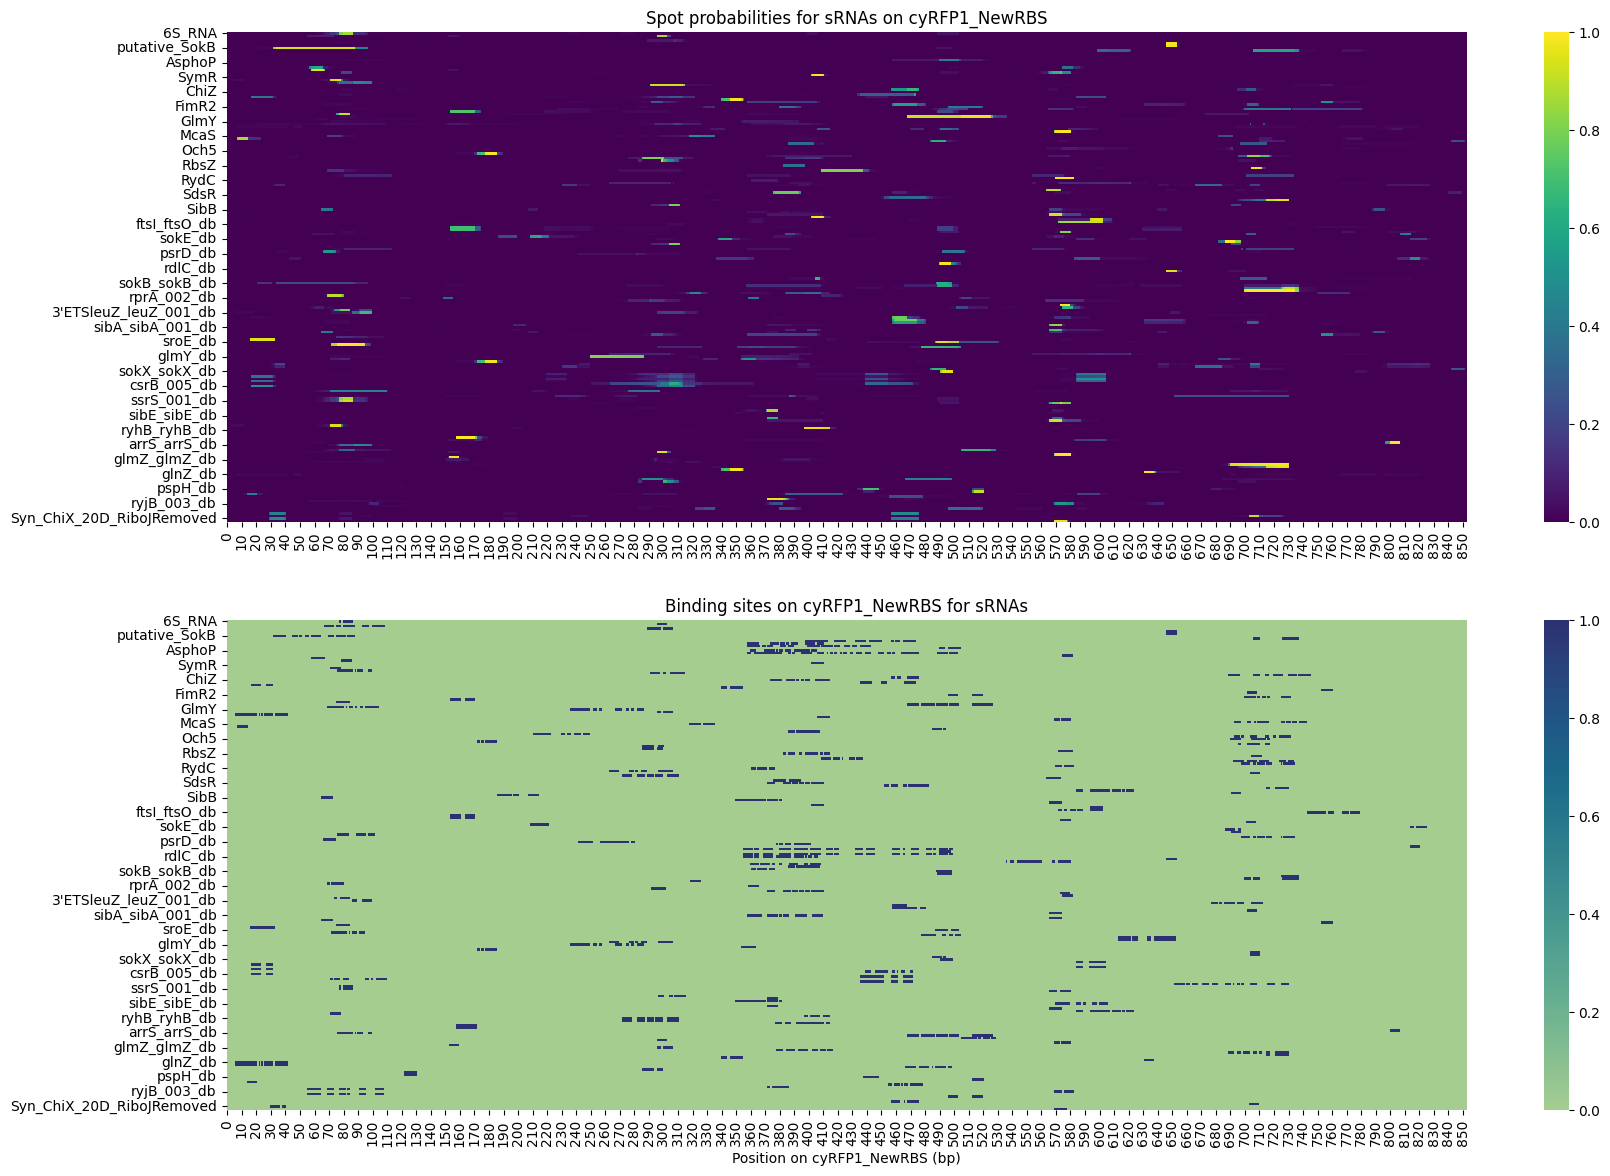

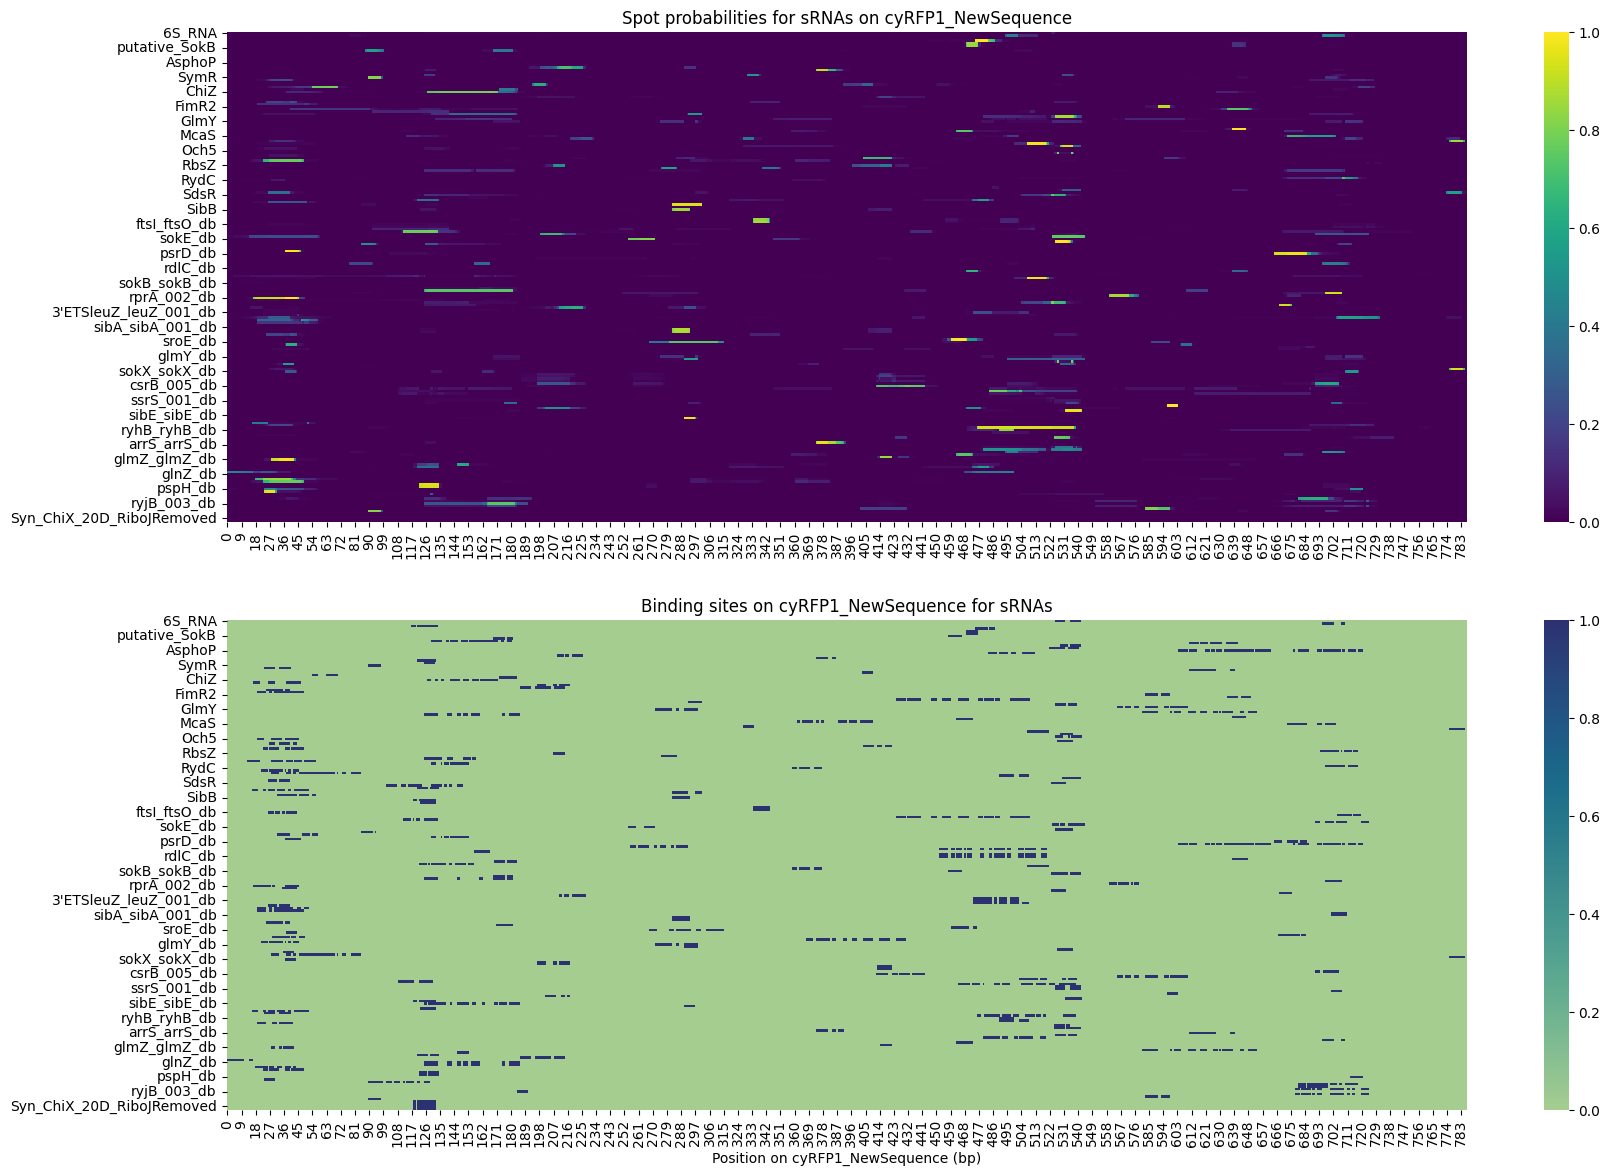

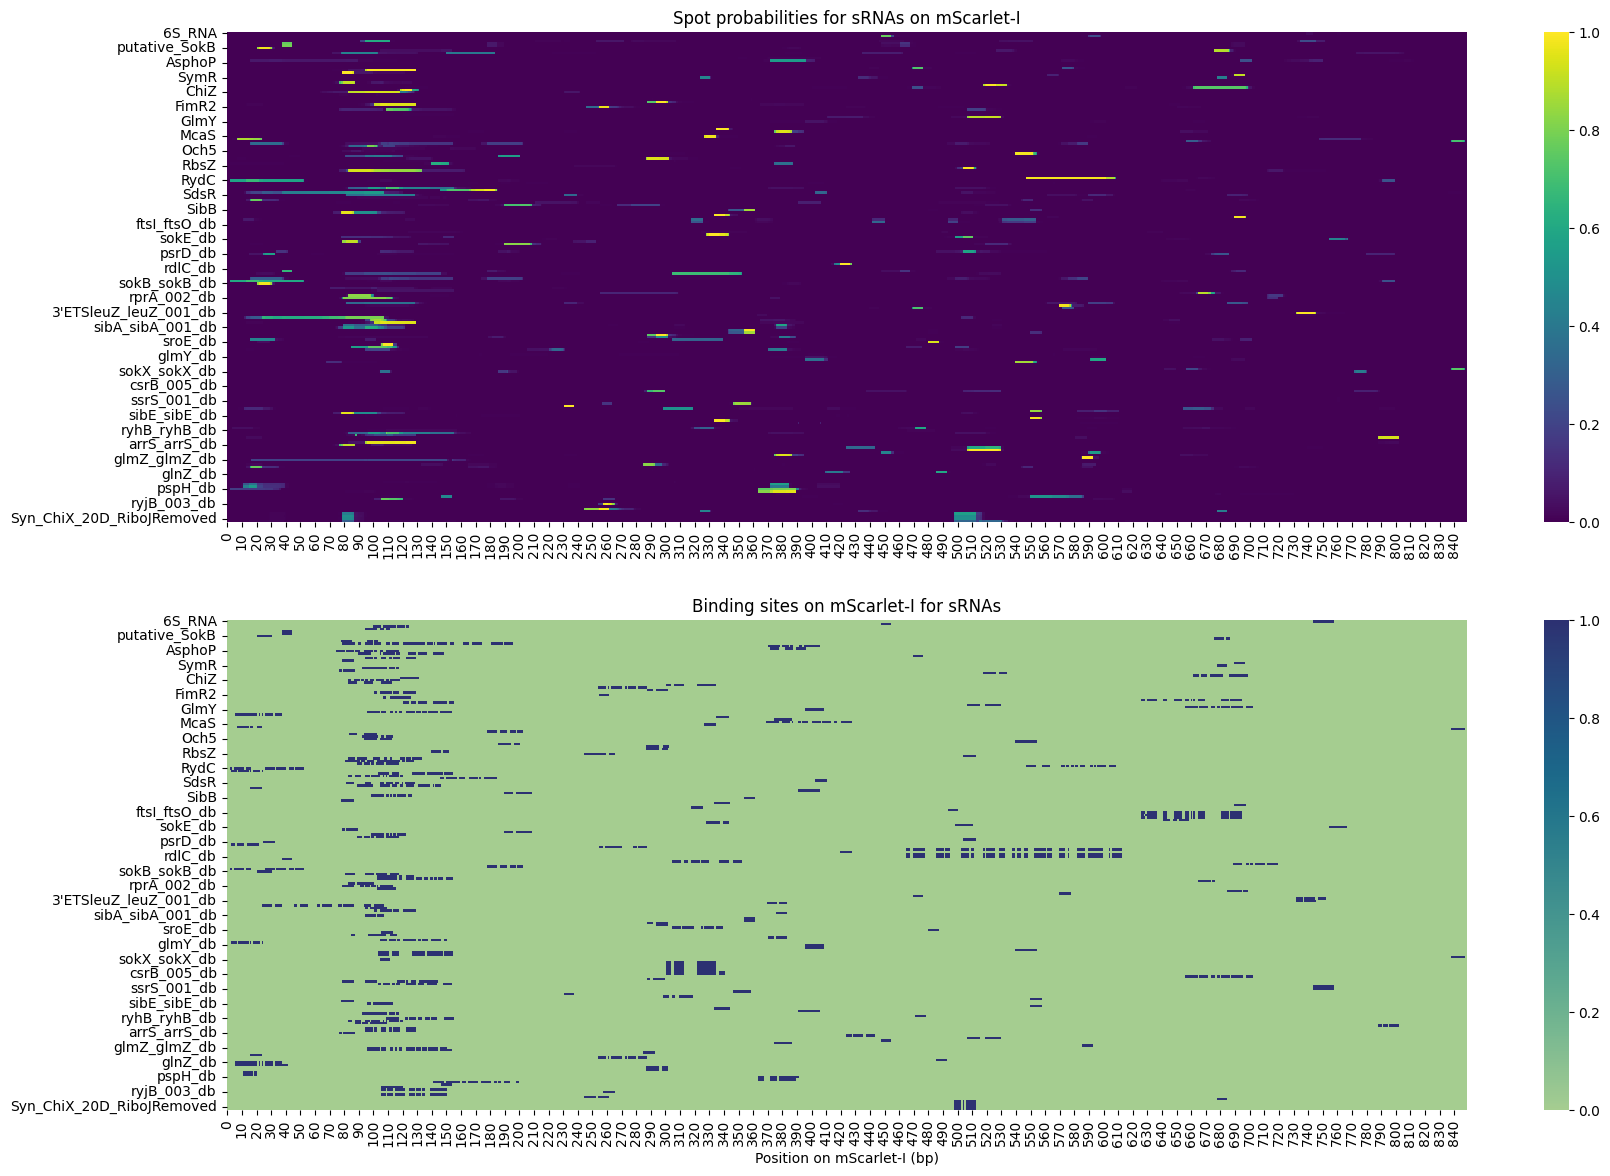

In [96]:
for i in range(len(cols_fps)):
    plt.figure(figsize=(20, 7*2))
    ax = plt.subplot(2,1,1)
    sns.heatmap(fps_spot[cols_fps[i]][srnas.keys()].T, cmap='viridis')
    plt.title(f'Spot probabilities for sRNAs on {cols_fps[i]}')

    ax = plt.subplot(2,1,2)
    sns.heatmap(binding_pos[cols_fps[i]].T[srnas.keys()].T, cmap='crest')
    plt.xlabel(f'Position on {cols_fps[i]} (bp)')
    plt.title(f'Binding sites on {cols_fps[i]} for sRNAs')

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: Us

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


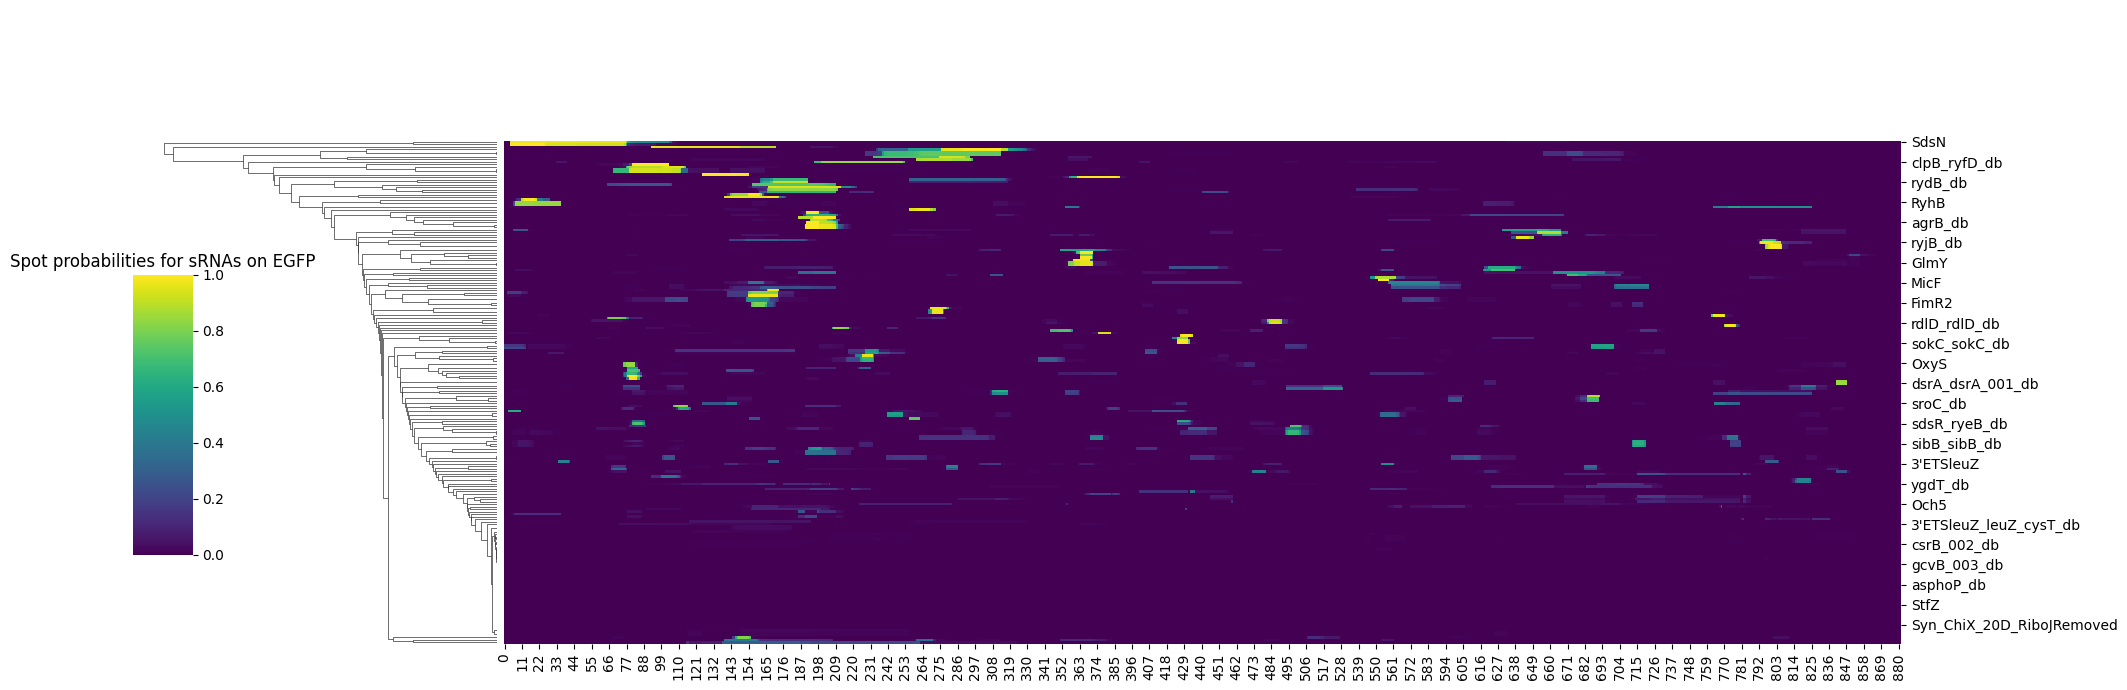

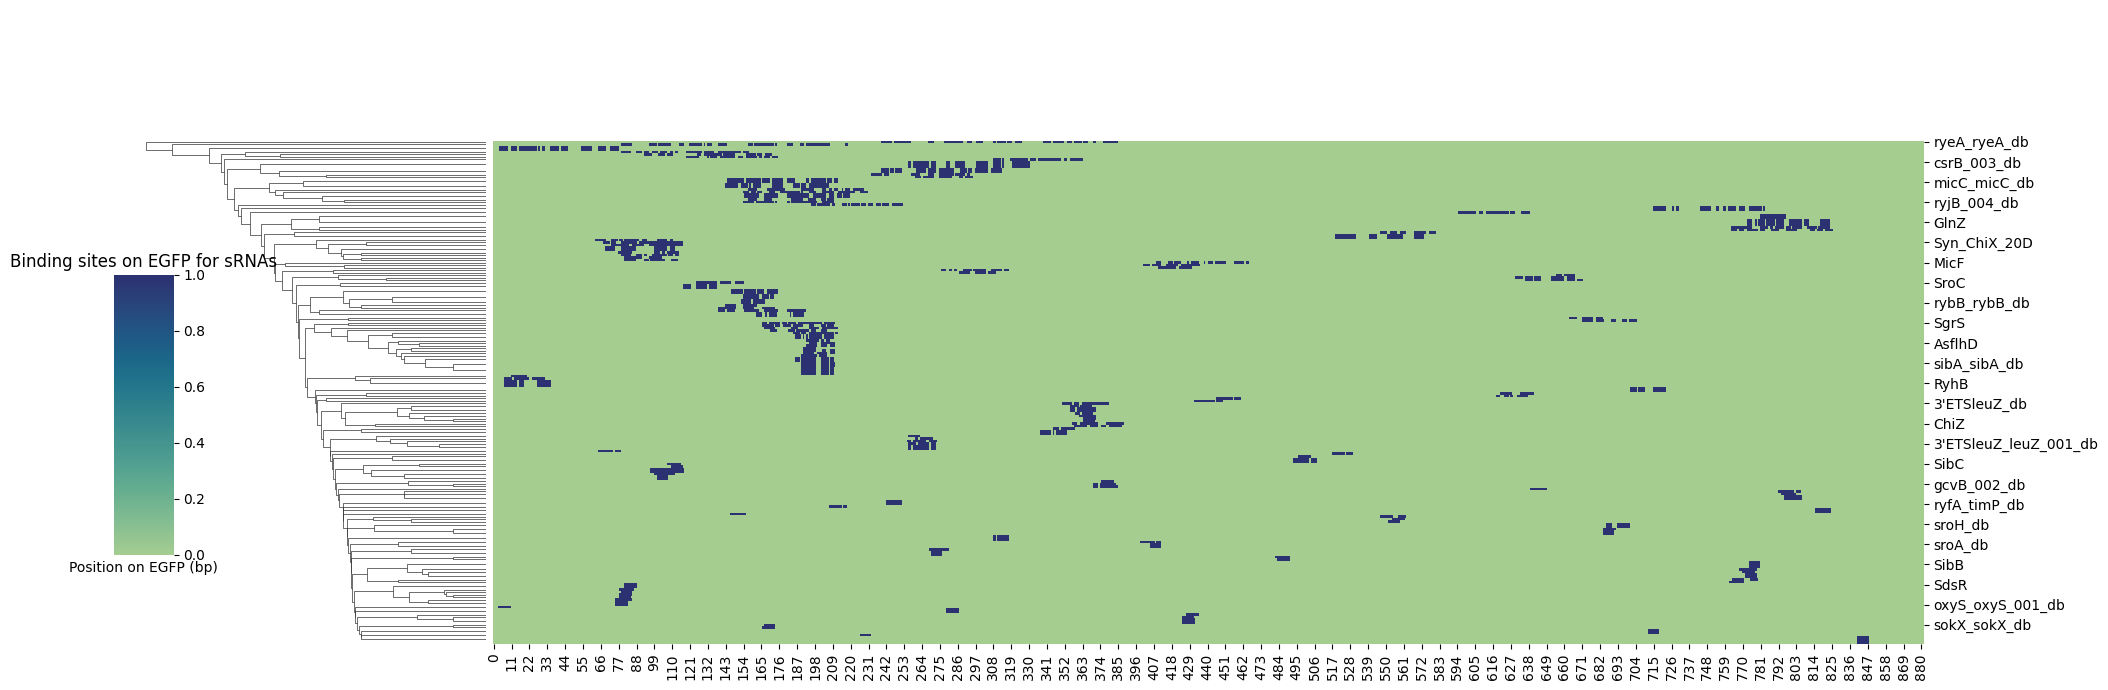

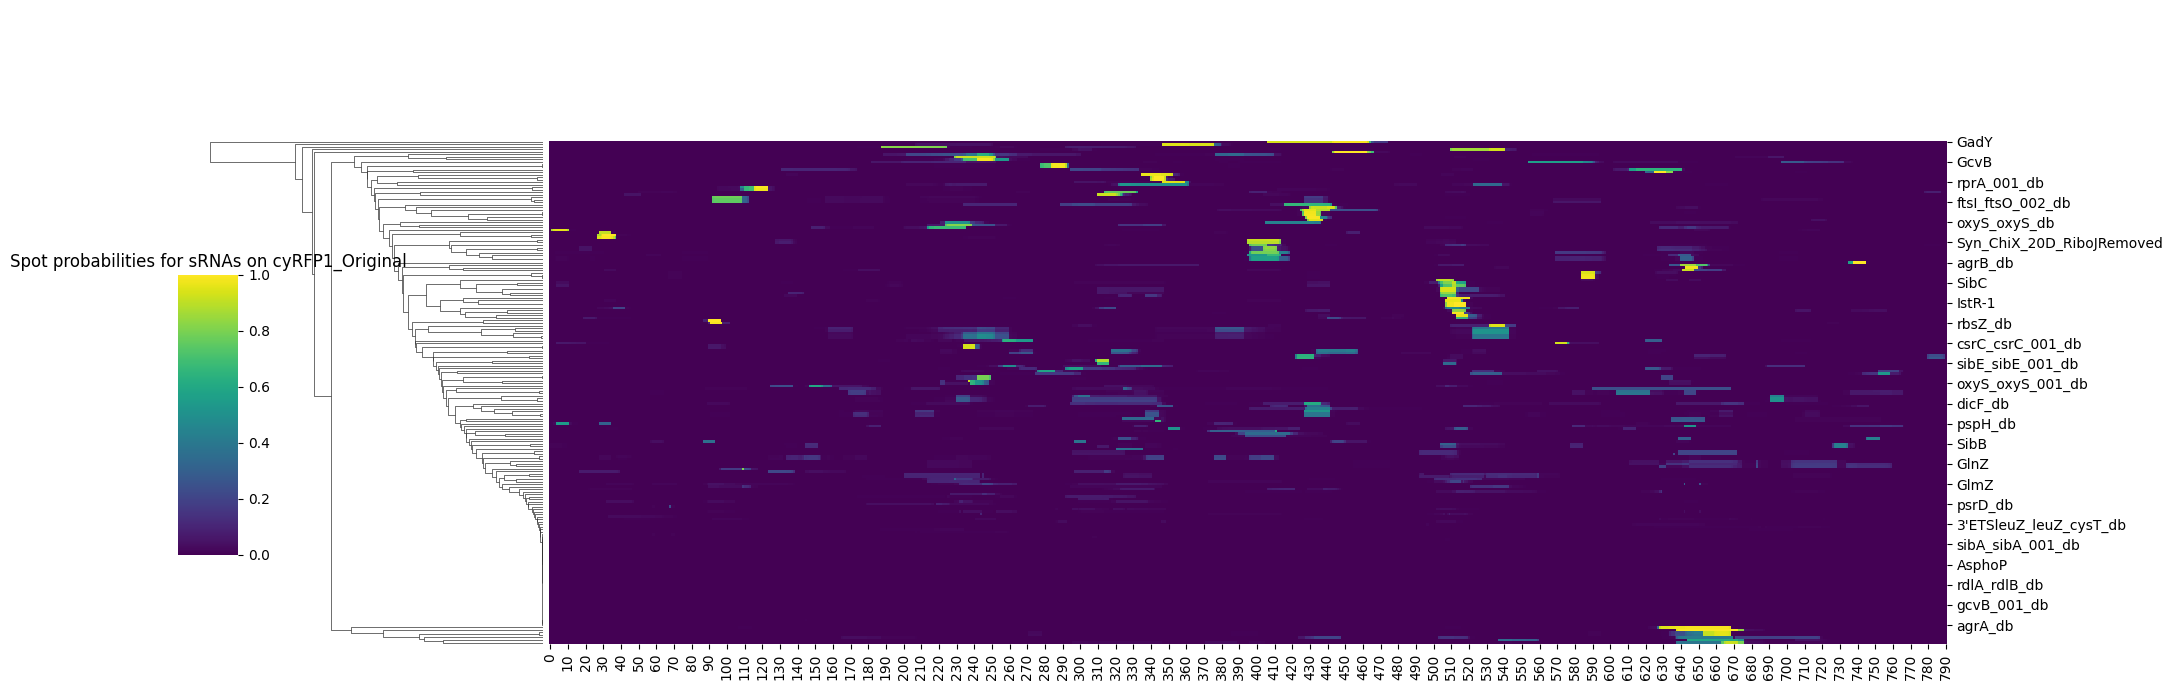

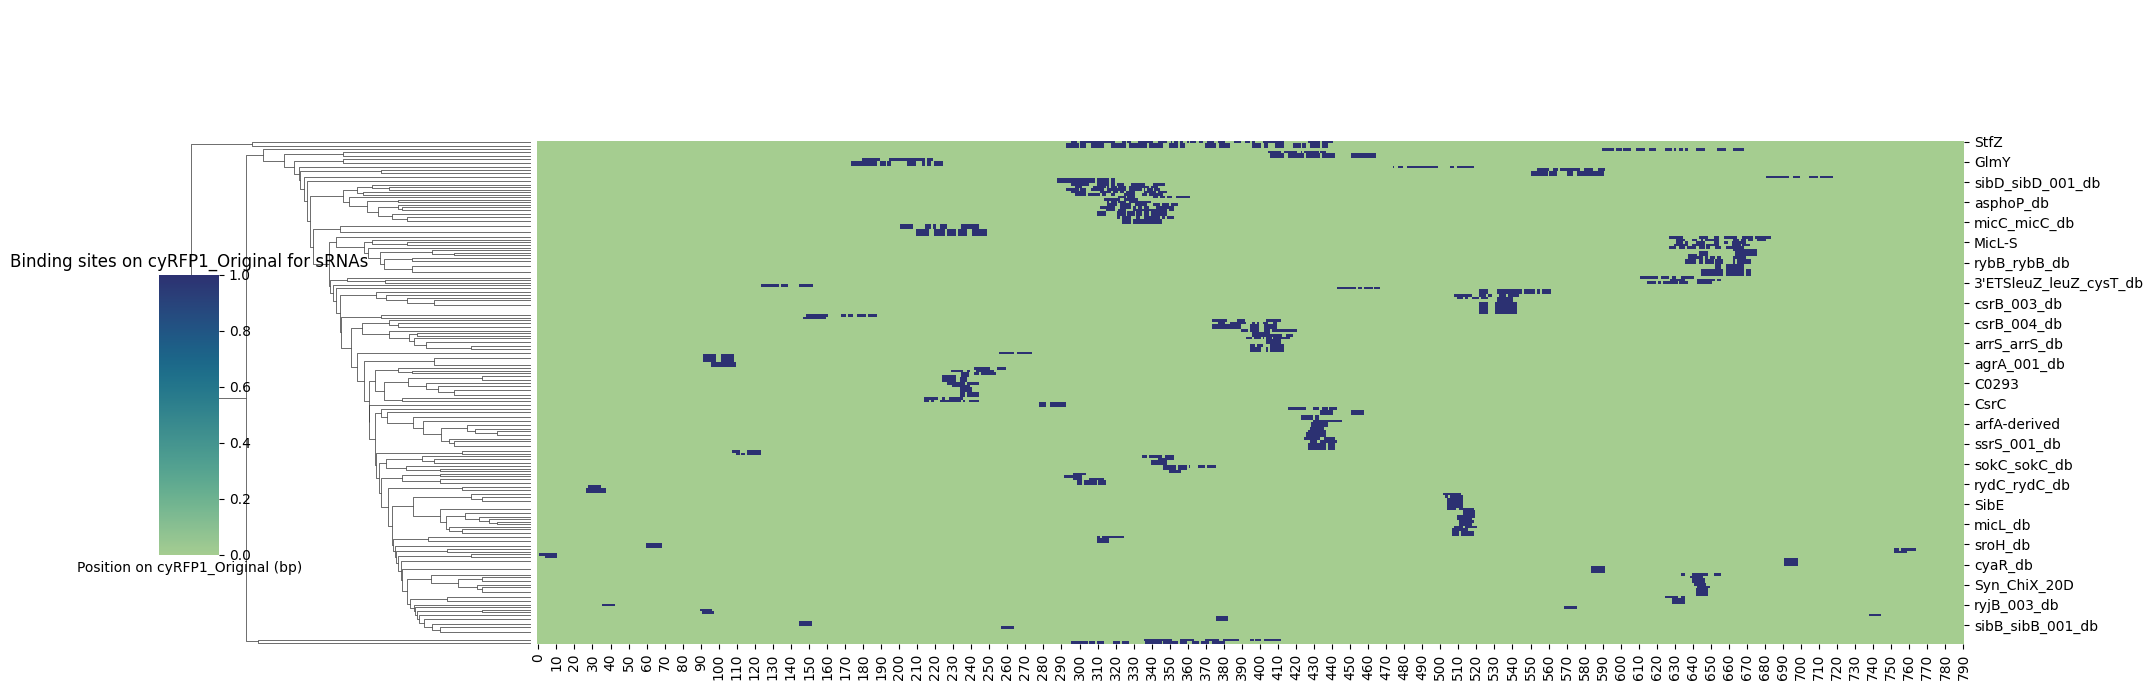

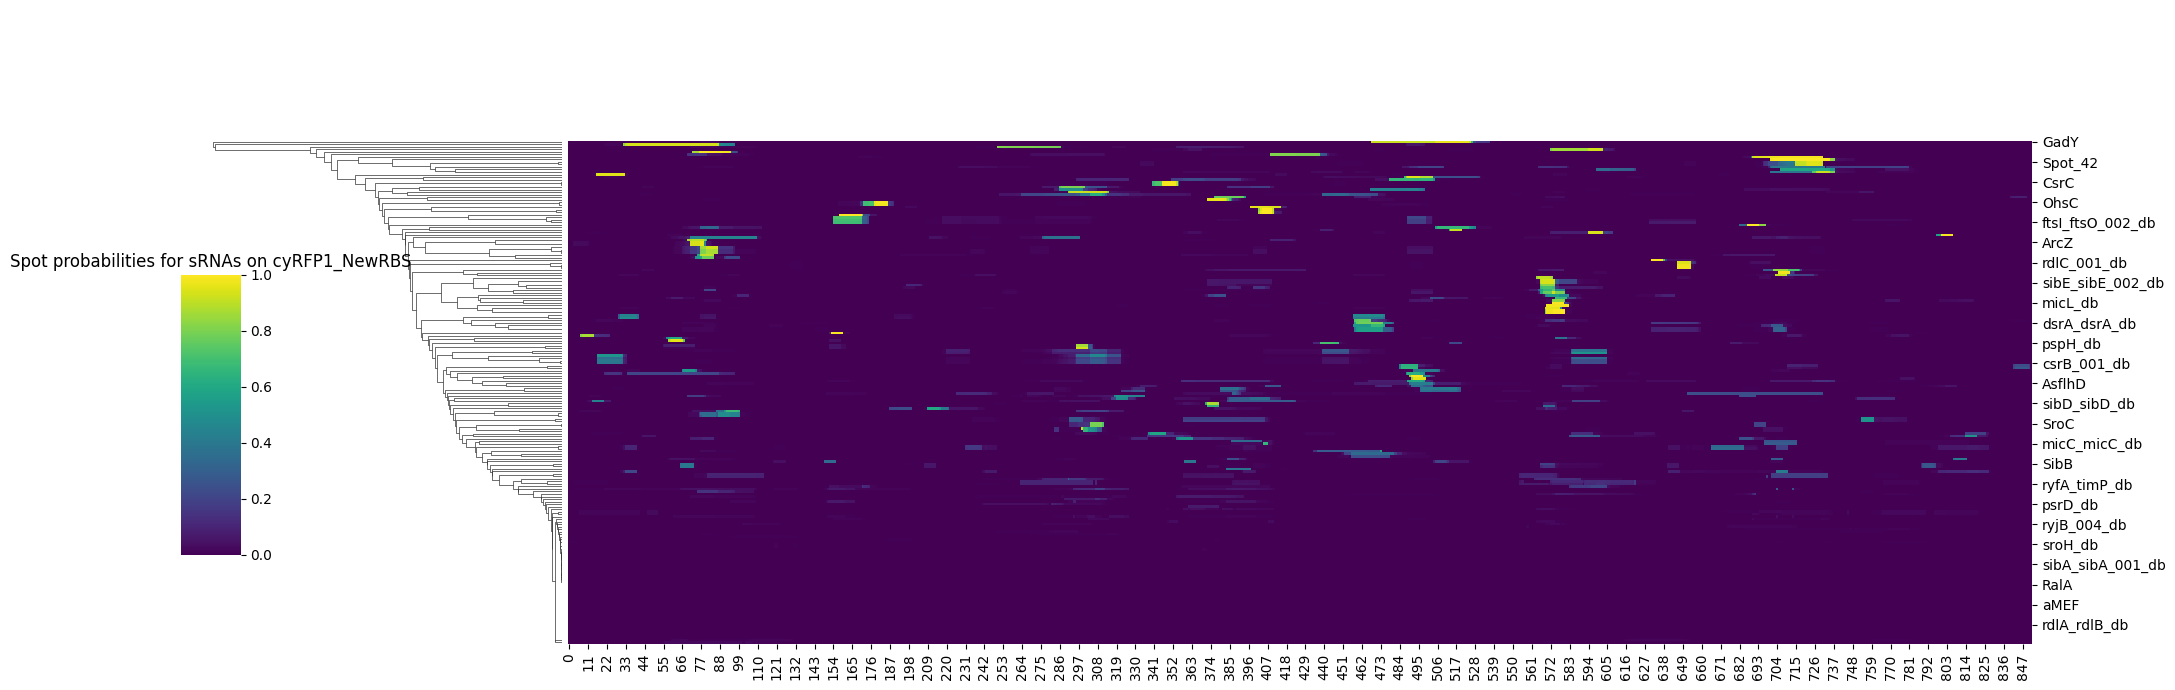

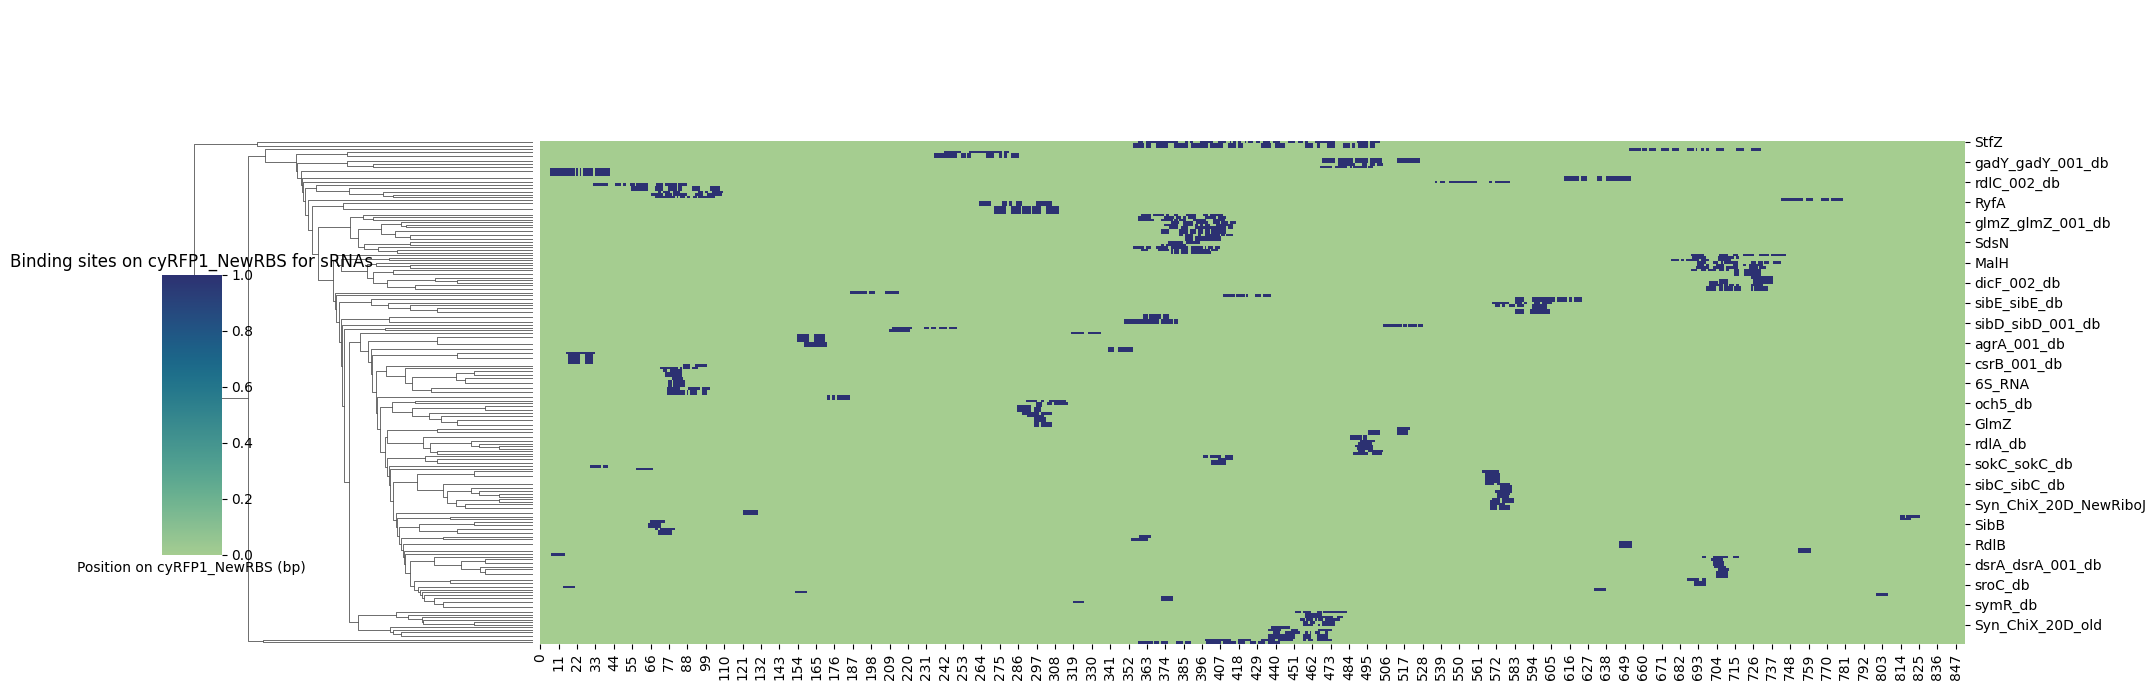

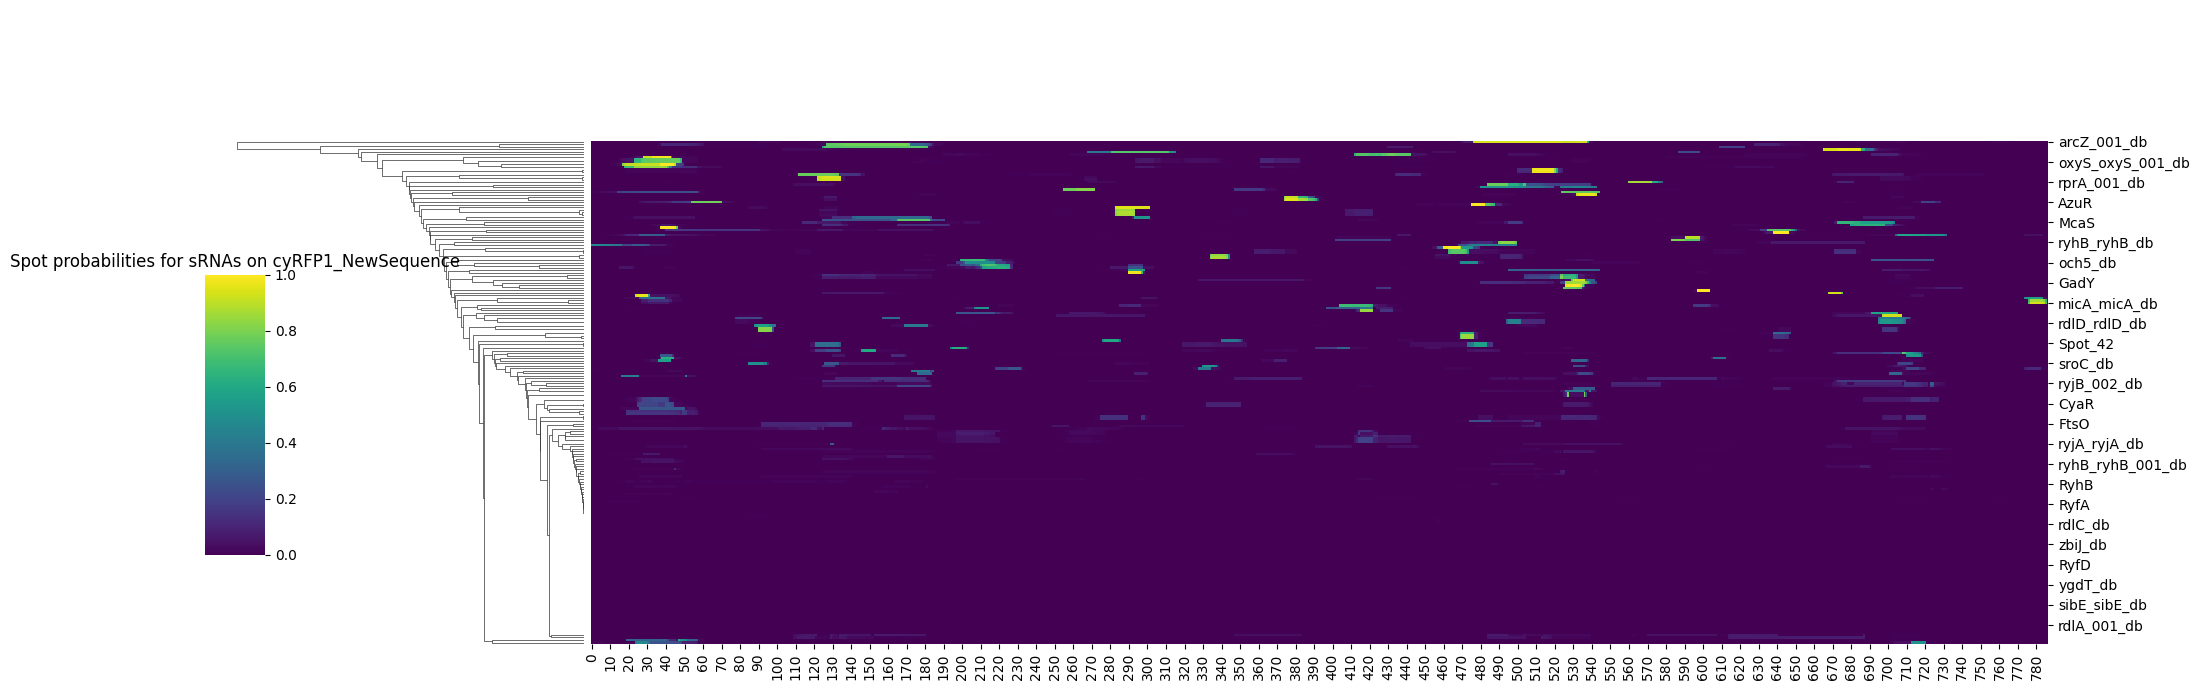

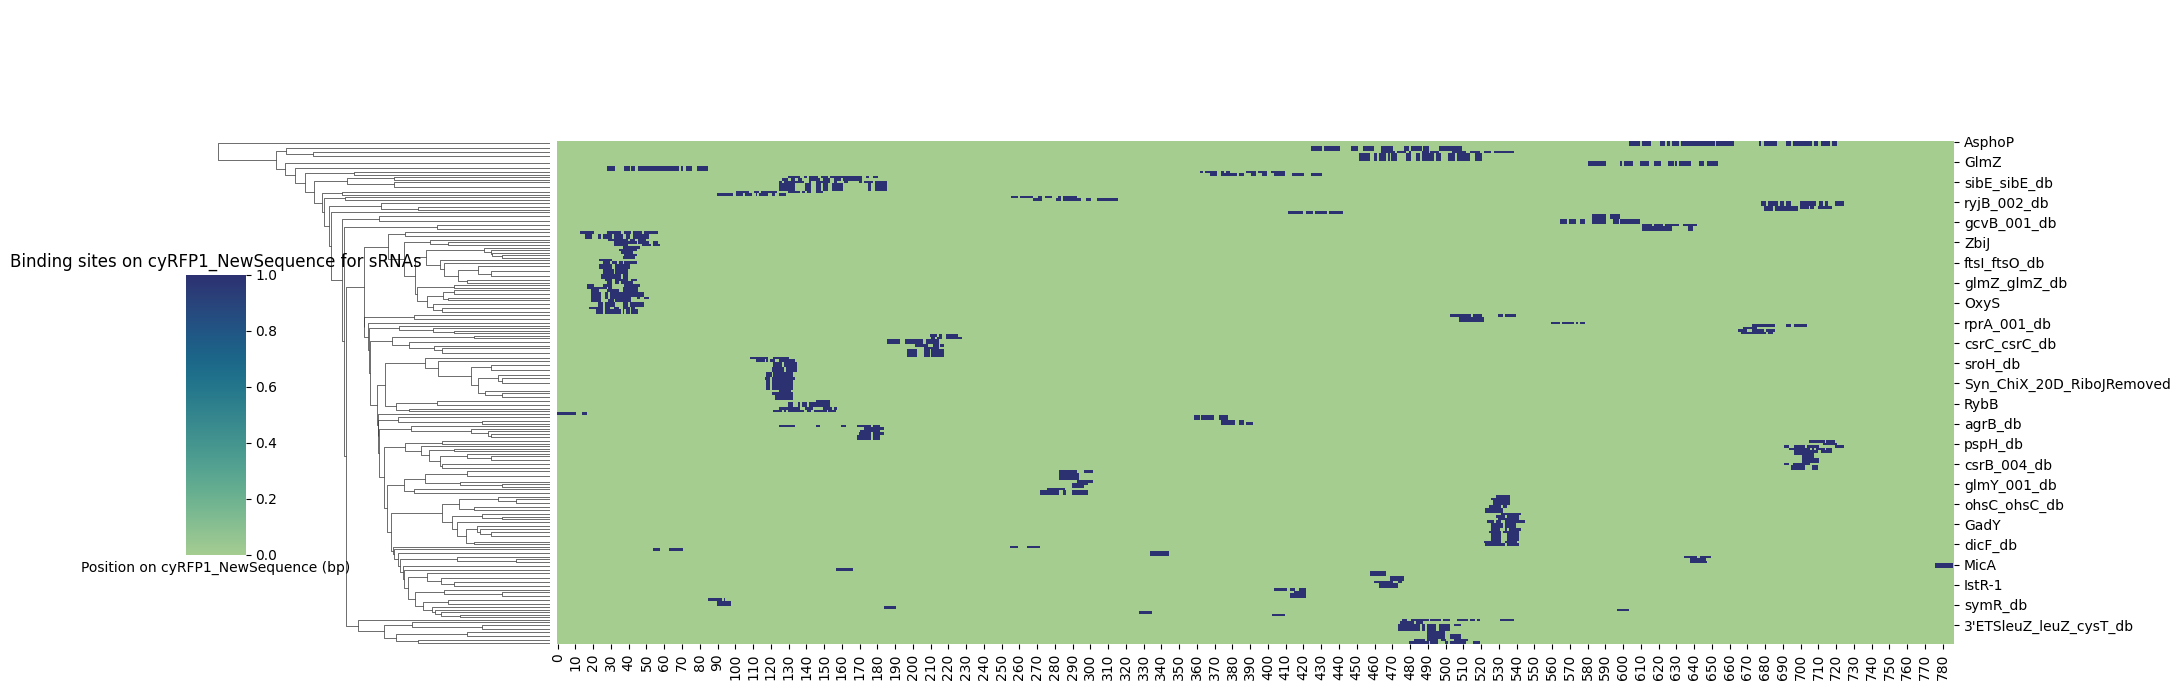

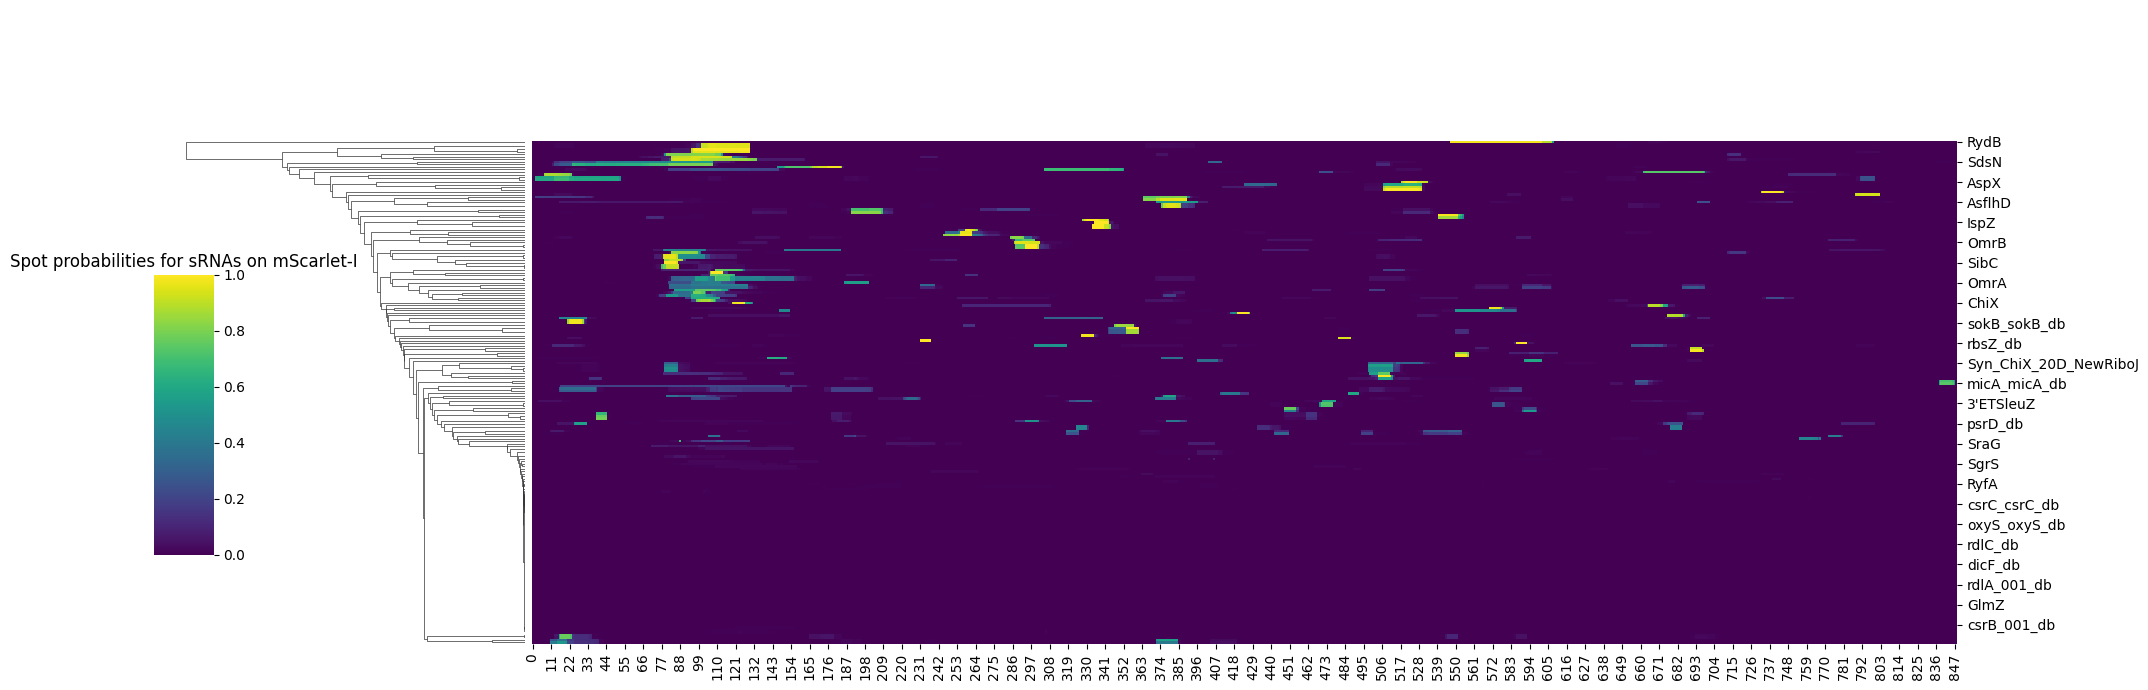

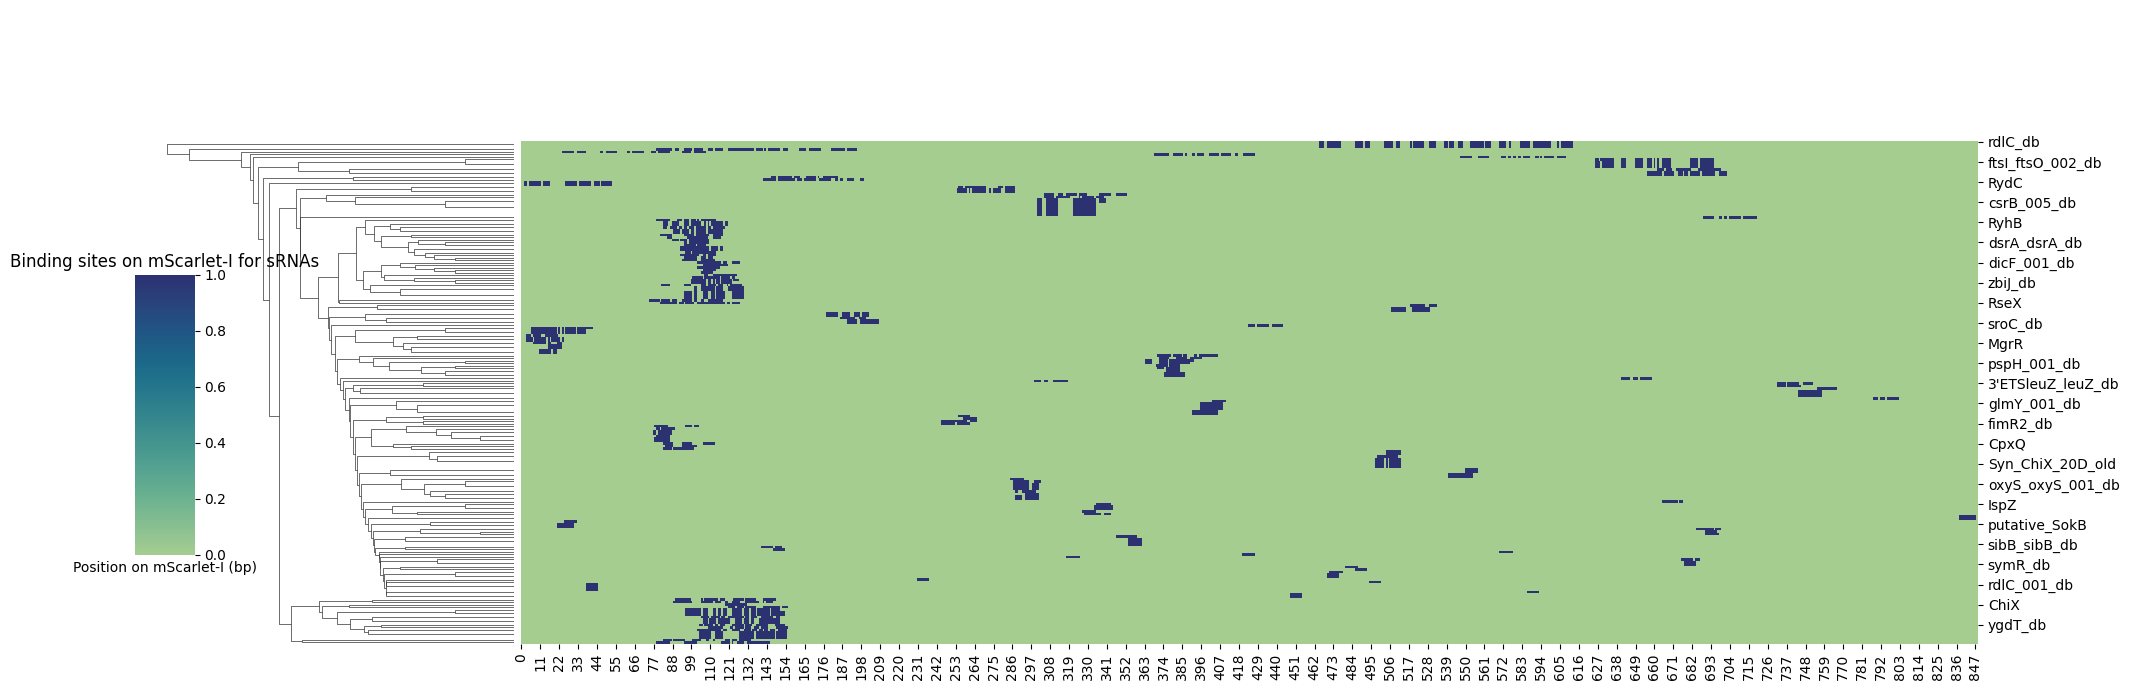

In [97]:
for i in range(len(cols_fps)):
    sns.clustermap(fps_spot[cols_fps[i]][srnas.keys()].T, cmap='viridis', figsize=(20, 7), col_cluster=False, cbar_pos=(0, .2, .03, .4))
    plt.title(f'Spot probabilities for sRNAs on {cols_fps[i]}')

    sns.clustermap(binding_pos[cols_fps[i]].T[srnas.keys()].T, cmap='crest', figsize=(20, 7), col_cluster=False, cbar_pos=(0, .2, .03, .4))
    plt.xlabel(f'Position on {cols_fps[i]} (bp)')
    plt.title(f'Binding sites on {cols_fps[i]} for sRNAs')

## Interpretations

#### Ratio from EGFP to cyRFP

In [98]:
print('sRNAs with the biggest ratio from EGFP to cyRFP1 (binding energy)')
n = 15
for i in range(len(cols_cyrfp_ratios)):
    energies = energies.sort_values(cols_cyrfp_ratios[i], ascending=False)
    print(f'{cols_cyrfp_ratios[i]}:'.ljust(30), f'Max ratio: {energies[cols_cyrfp_ratios[i]].max():.2f}\t', energies.iloc[:n].index.to_list())
    # energies[cols_fps + [cols_cyrfp_ratios[i]]].iloc[:15]

sRNAs with the biggest ratio from EGFP to cyRFP1 (binding energy)
EGFP / cyRFP1_Original:        Max ratio: 5.10	 ['sibE_sibE_001_db', 'Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'Syn_ChiX_20D_NewRiboJ', 'arcZ_db', 'ArcZ', 'GadF', 'Syn_ChiX_20D', 'ryjB_003_db', 'sibB_sibB_db', 'AgrB', 'csrB_004_db', 'sraA_db', 'SibC', 'IspZ']
EGFP / cyRFP1_NewRBS:          Max ratio: 5.10	 ['sibE_sibE_001_db', 'Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'Syn_ChiX_20D_NewRiboJ', 'Syn_ChiX_20D', 'ryjB_003_db', 'sibB_sibB_db', 'GadF', 'csrB_004_db', 'sraA_db', 'pspH_db', 'AgrB', 'IspZ', 'arcZ_db', 'ArcZ']
EGFP / cyRFP1_NewSequence:     Max ratio: 4.90	 ['SokC', 'xtpA_yahM_db', 'OmrB', "3'ETSleuZ_db", 'kilS_db', 'Syn_ChiX_20D_NewRiboJ', "3'ETSleuZ", 'Syn_ChiX_20D', 'Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'och5_db', 'micC_micC_db', 'MicC', 'C0293', 'pspH_db']


#### sRNAs with strongest binding to FPs

In [99]:
n = 18
print('sRNAs with the strongest binding energy:')
for i in range(len(cols_fps)):
    energies = energies.sort_values(cols_fps[i], ascending=True)
    print(f'{cols_fps[i]}:'.ljust(20), f'Min E: {energies[cols_fps[i]].min():.2f}\t', energies.iloc[:n].index.to_list())
    # energies[cols_fps].iloc[:n]

sRNAs with the strongest binding energy:
EGFP:                Min E: -27.73	 ['Syn_ChiX_20D_NewRiboJ', 'Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'Syn_ChiX_20D', 'kilS_db', 'GlmZ', 'glmZ_glmZ_001_db', 'xtpA_yahM_db', 'aMEF', 'StfZ', 'rdlC_002_db', 'SraG', 'asphoP_db', 'AsphoP', 'MicL-S', 'MicC', 'rdlA_rdlB_db', 'rdlA_001_db']
cyRFP1_Original:     Min E: -29.92	 ['StfZ', 'AsCRP', 'rdlA_rdlB_db', 'rdlA_001_db', 'gcvB_001_db', 'gcvB_003_db', 'RseX', 'aMEF', 'MalH', 'sibE_sibE_db', 'ZbiJ', 'AsphoP', 'rdlC_db', 'timR_001_db', 'rdlC_002_db', 'timR_002_db', 'sraG_psrO_db', 'kilS_db']
cyRFP1_NewRBS:       Min E: -29.92	 ['StfZ', 'AsCRP', 'rdlA_rdlB_db', 'rdlA_001_db', 'gcvB_001_db', 'gcvB_003_db', 'RseX', 'arfA-derived', 'aMEF', 'MalH', 'sibE_sibE_db', 'AsphoP', 'rdlC_db', 'ZbiJ', 'timR_001_db', 'rdlC_002_db', 'timR_002_db', 'sraG_psrO_db']
cyRFP1_NewSequence:  Min E: -25.87	 ['AsphoP', 'asphoP_db', 'agrA_agrB_db', 'aMEF', 'sibE_sibE_db', 'SibD', 'RseX', 'sibD_sibD_001_db', 'ArrS', 'arrS

#### Differences in binding energies: largest

In [100]:
n = 10
print('sRNAs with the largest difference in binding energy between EGFP:')
for i in range(len(cols_cyrfp_diffs)):
    energies = energies.sort_values(cols_cyrfp_diffs[i], ascending=False)
    print(f'{cols_cyrfp_diffs[i]}:'.ljust(30), f'Max diff: {energies[cols_cyrfp_diffs[i]].max():.2f}\t', energies.iloc[:n].index.to_list())
    # energies[cols_cyrfp_diffs + cols_fps].iloc[:n]

sRNAs with the largest difference in binding energy between EGFP:
EGFP - cyRFP1_Original:        Max diff: 19.52	 ['Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'Syn_ChiX_20D_NewRiboJ', 'Syn_ChiX_20D', 'StfZ', 'GadF', 'arcZ_db', 'ArcZ', 'xtpA_yahM_db', 'PspH']
EGFP - cyRFP1_NewRBS:          Max diff: 19.47	 ['Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'Syn_ChiX_20D_NewRiboJ', 'Syn_ChiX_20D', 'StfZ', 'xtpA_yahM_db', 'arfA-derived', 'PspH', 'GlmZ', 'kilS_db']
EGFP - cyRFP1_NewSequence:     Max diff: 11.97	 ['Syn_ChiX_20D_NewRiboJ', 'Syn_ChiX_20D', 'Syn_ChiX_20D_RiboJRemoved', 'Syn_ChiX_20D_old', 'ArrS', 'xtpA_yahM_db', 'kilS_db', 'AsphoP', 'arrS_arrS_db', 'asphoP_db']


#### Differences in binding energies: smallest

In [101]:
n = 10
print('sRNAs with the smallest difference in binding energy between EGFP:')
for i in range(len(cols_cyrfp_diffs)):
    energies = energies.sort_values(cols_cyrfp_diffs[i])
    print(f'{cols_cyrfp_diffs[i]}:'.ljust(30), f'Min diff: {energies[cols_cyrfp_diffs[i]].min():.2f}\t', energies.iloc[:n].index.to_list())
    # energies[cols_cyrfp_diffs + cols_fps].iloc[:n]

sRNAs with the smallest difference in binding energy between EGFP:
EGFP - cyRFP1_Original:        Min diff: 0.02	 ['McaS', 'AsphoP', 'MicA', 'C0293', 'AspX', 'flgO_db', 'RprA', 'ygdT_db', 'SgrS', 'RbsZ']
EGFP - cyRFP1_NewRBS:          Min diff: 0.02	 ['McaS', 'flgO_db', 'pspH_001_db', 'AsphoP', 'MicA', 'C0293', 'AspX', 'glnZ_001_db', 'RprA', 'ygdT_db']
EGFP - cyRFP1_NewSequence:     Min diff: 0.07	 ['MicA', 'AsCRP', 'DicF', 'micL_db', 'ChiZ', 'RydB', 'gcvB_002_db', 'micA_micA_db', 'ftsI_ftsO_002_db', 'rydB_db']


### Interpretations for sRNA's from new database (Nov 2024)

In [102]:
cols_extradb = [c for c in energies.T.columns if '_db' in c]

n = 15
print('sRNAs from new database (Nov 2024) that could be interfering with')
for i in range(len(cols_fps)):
    energies = energies.sort_values(cols_fps[i], ascending=True)
    print(f'{cols_fps[i]}:'.ljust(25), f'Min E: {energies.loc[cols_extradb, cols_fps[i]].min():.2f}\t', energies.loc[cols_extradb, cols_fps].sort_values(cols_fps[i], ascending=True).iloc[:n].index.to_list())
    # energies.T[cols_extradb].T[cols_fps].iloc[:n]


sRNAs from new database (Nov 2024) that could be interfering with
EGFP:                     Min E: -22.48	 ['kilS_db', 'glmZ_glmZ_001_db', 'xtpA_yahM_db', 'rdlC_002_db', 'asphoP_db', 'rdlA_rdlB_db', 'rdlA_001_db', 'micC_micC_db', 'ryjB_002_db', 'ryjB_004_db', 'gcvB_001_db', 'glmZ_glmZ_db', 'gcvB_003_db', 'sibE_sibE_db', 'ryeA_ryeA_db']
cyRFP1_Original:          Min E: -20.52	 ['rdlA_rdlB_db', 'rdlA_001_db', 'gcvB_001_db', 'gcvB_003_db', 'sibE_sibE_db', 'rdlC_db', 'timR_001_db', 'rdlC_002_db', 'timR_002_db', 'sraG_psrO_db', 'kilS_db', 'ryhB_ryhB_001_db', 'agrA_db', 'asphoP_db', "3'ETSleuZ_leuZ_cysT_db"]
cyRFP1_NewRBS:            Min E: -20.52	 ['rdlA_rdlB_db', 'rdlA_001_db', 'gcvB_001_db', 'gcvB_003_db', 'sibE_sibE_db', 'rdlC_db', 'timR_001_db', 'rdlC_002_db', 'timR_002_db', 'sraG_psrO_db', 'kilS_db', 'ryhB_ryhB_001_db', 'agrA_db', 'asphoP_db', 'zbiJ_db']
cyRFP1_NewSequence:       Min E: -25.87	 ['asphoP_db', 'agrA_agrB_db', 'sibE_sibE_db', 'sibD_sibD_001_db', 'arrS_arrS_db', 'timR_002_

In [103]:
n = 15
print('sRNAs from new database (Nov 2024) with largest difference in binding energy between cyRFP1 and EGFP:')
for i in range(len(cols_cyrfp_diffs)):
    energies = energies.sort_values(cols_cyrfp_diffs[i], ascending=True)
    print(f'{cols_cyrfp_diffs[i]}:'.ljust(30), f'Max diff: {energies.loc[cols_extradb, cols_cyrfp_diffs[i]].max():.2f}\t', energies.loc[cols_extradb, cols_cyrfp_diffs].sort_values(cols_cyrfp_diffs[i], ascending=True).iloc[:n].index.to_list())
    # energies.T[cols_extradb].T[cols_cyrfp_diffs].iloc[:n]

sRNAs from new database (Nov 2024) with largest difference in binding energy between cyRFP1 and EGFP:
EGFP - cyRFP1_Original:        Max diff: 8.56	 ['flgO_db', 'ygdT_db', 'ftsI_ftsO_db', 'clpB_ryfD_db', 'sibD_sibD_db', 'micA_micA_db', 'arcZ_001_db', 'ohsC_ohsC_db', 'ipeX_db', 'dicF_002_db', 'ftsI_ftsO_001_db', 'dicF_db', "3'ETSleuZ_leuZ_cysT_db", 'csrC_csrC_001_db', 'ryfA_timP_db']
EGFP - cyRFP1_NewRBS:          Max diff: 8.56	 ['flgO_db', 'pspH_001_db', 'glnZ_001_db', 'ygdT_db', 'ftsI_ftsO_db', 'clpB_ryfD_db', 'sibD_sibD_db', 'micA_micA_db', 'arcZ_001_db', 'dicF_002_db', 'sibB_sibB_001_db', 'ipeX_db', 'ohsC_ohsC_db', 'dicF_db', "3'ETSleuZ_leuZ_cysT_db"]
EGFP - cyRFP1_NewSequence:     Max diff: 9.80	 ['micL_db', 'gcvB_002_db', 'micA_micA_db', 'ftsI_ftsO_002_db', 'rydB_db', 'rdlA_db', "3'ETSleuZ_leuZ_cysT_db", "3'ETSleuZ_leuZ_001_db", 'arcZ_001_db', 'sokE_db', 'istR_db', 'sibC_sibC_db', 'sokX_sokX_db', 'ftsI_ftsO_db', 'rdlD_rdlD_db']


## Positions

#### Binding positions on FPs

In [106]:
sim_data_l['Syn_ChiX_20D']['EGFP']

{'id1': 'Syn_ChiX_20D',
 'id2': 'EGFP',
 'E': '-26.62',
 'E_norm': '-2.21102',
 'bpList': '(85,117):(86,116):(87,115):(88,114):(89,113):(90,112):(91,111):(92,110):(93,109):(94,108):(95,107):(96,106):(97,105):(98,104):(99,103):(100,102):(101,101):(102,100):(103,99):(104,98):(105,97):(116,96):(117,95):(118,94):(119,93):(120,92):(121,91):(124,89):(125,88):(126,87):(127,86):(128,85):(129,84):(130,83):(131,82):(132,81):(133,80):(136,76):(137,75):(138,74):(139,72):(140,71):(141,70):(142,69)',
 'hybridDPfull': '....................................................................................(((((((((((((((((((((..........((((((..((((((((((..(((((((..................................................&....................................................................)))).)))...)))))))))).)))))))))))))))))))))))))))....................................................................................................................................................................................

## Fluorescent proteins vs. sRNA interference

Text(0.5, 1.0, 'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol) - difference to SynChiX $/Delta$G\n(negative values indicate stronger binding than SynChiX)')

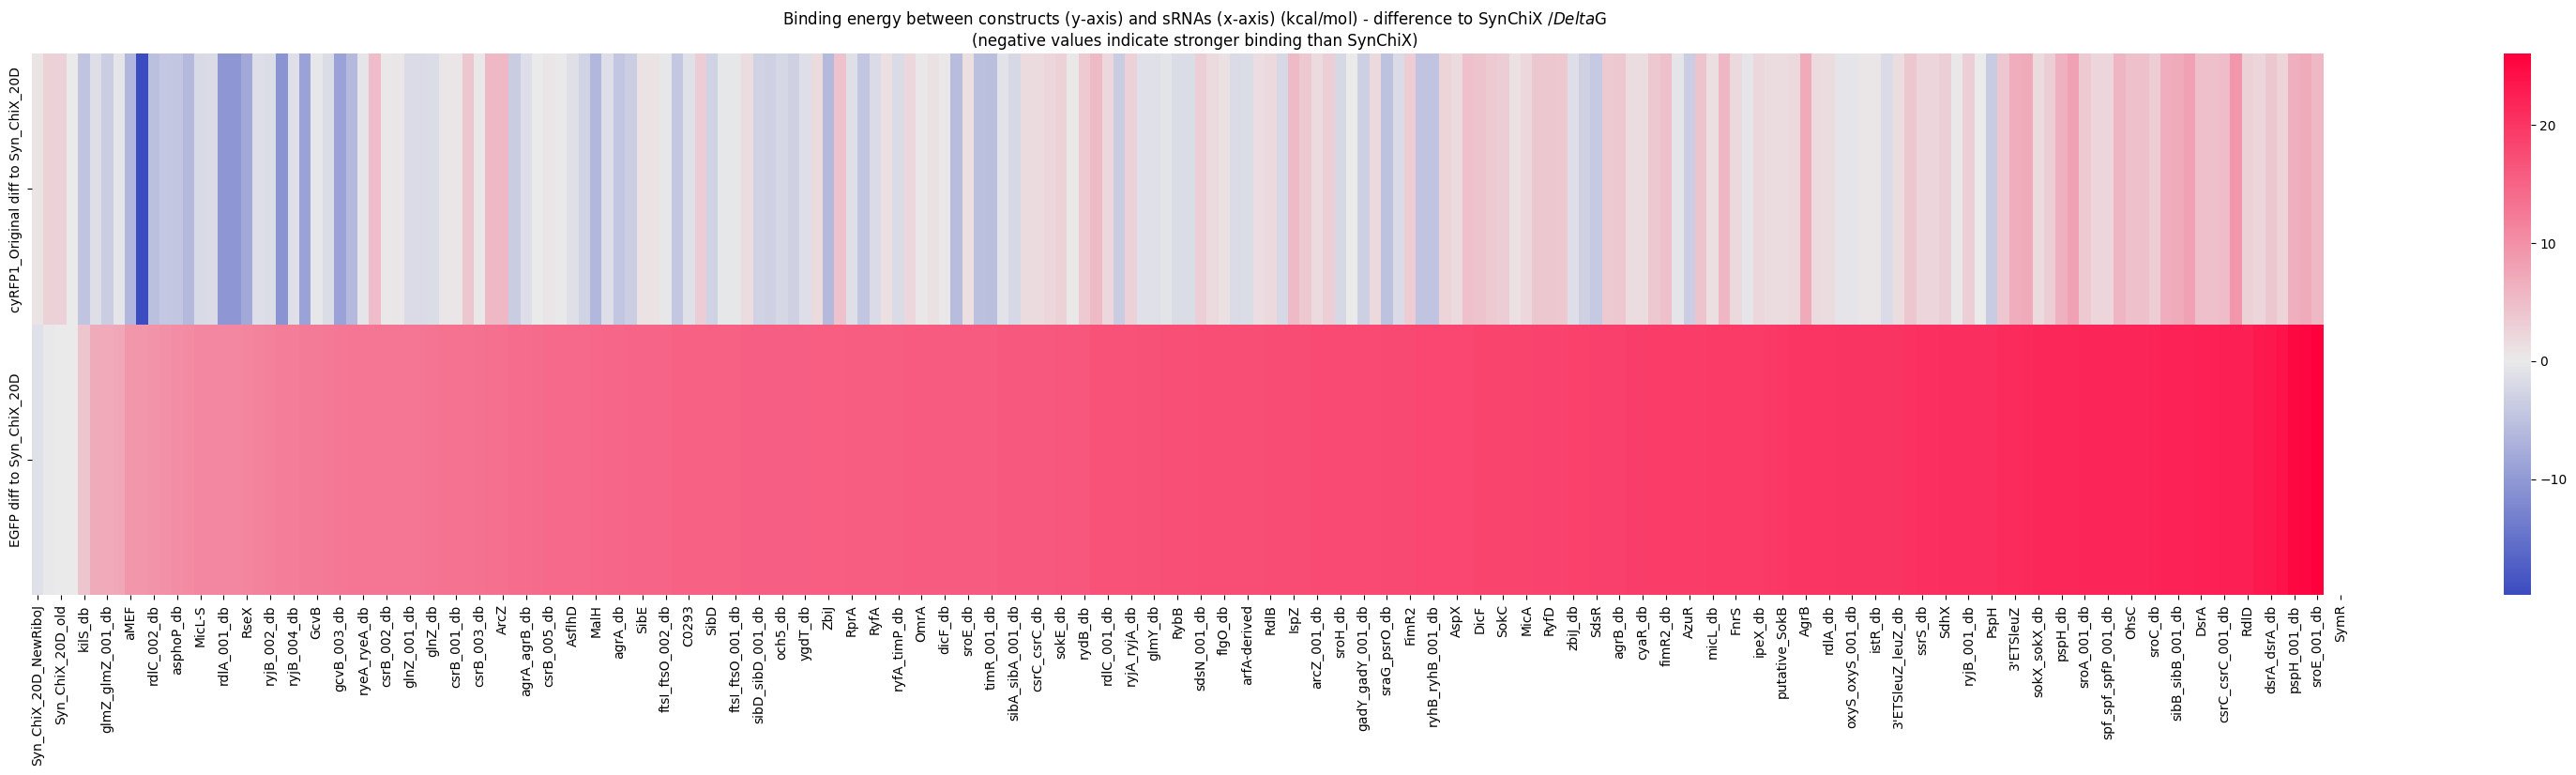

In [121]:
fig = plt.figure(figsize=(40, 2*9))
fig.subplots_adjust(hspace=0.4)

# ax = plt.subplot(2,1,1)
# sns.heatmap(energies)
# plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

def make_diverging(x, center=1, cool_color=cool_color, center_color=center_color_l, warm_color=warm_color):
    colors = [(0, cool_color), (center/(np.max(x) - np.min(x)), center_color), (1, warm_color)]
    return LinearSegmentedColormap.from_list("custom_cmap", colors)
    
energies['cyRFP1_Original diff to Syn_ChiX_20D'] = energies['cyRFP1_Original'] - energies['cyRFP1_Original']['Syn_ChiX_20D']
energies['EGFP diff to Syn_ChiX_20D'] = energies['EGFP'] - energies['EGFP']['Syn_ChiX_20D']
energies = energies.sort_values('EGFP diff to Syn_ChiX_20D')
ax = plt.subplot(2,1,1)
center = -np.min(energies[['cyRFP1_Original diff to Syn_ChiX_20D', 'EGFP diff to Syn_ChiX_20D']])
custom_map = make_diverging(energies[['cyRFP1_Original diff to Syn_ChiX_20D', 'EGFP diff to Syn_ChiX_20D']].T, center=center)
sns.heatmap(energies[['cyRFP1_Original diff to Syn_ChiX_20D', 'EGFP diff to Syn_ChiX_20D']].T, cmap=custom_map)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol) - difference to SynChiX $/Delta$G\n(negative values indicate stronger binding than SynChiX)')

In [ ]:
# pu1s = pd.DataFrame(data=np.array([[float(vv['seedPu1'].split(':')[0]) if vv['seedPu1'].split(':')[0] else 0 for vv in v.values()] for v in sim_data_l.values()]).T,
#                         columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
# pu2s = pd.DataFrame(data=np.array([[float(vv['seedPu2'].split(':')[0]) if vv['seedPu2'].split(':')[0] else 0 for vv in v.values()] for v in sim_data_l.values()]).T,
#                         columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
# pu1s = pu1s.sort_index()[sorted(pu1s.columns)]
# pu2s = pu2s.sort_index()[sorted(pu2s.columns)]

# fig = plt.figure(figsize=(19, 3*8))

# ax = plt.subplot(3,1,1)
# sns.heatmap(pu1s)
# plt.title('Seed probability of sRNA between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')
# ax = plt.subplot(3,1,2)
# sns.heatmap(pu2s)
# plt.title('Seed probability of constructs between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')
# ax = plt.subplot(3,1,3)
# sns.heatmap(pu1s/pu2s )
# plt.title('Seed probability ratio of constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

## Plot mutations

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

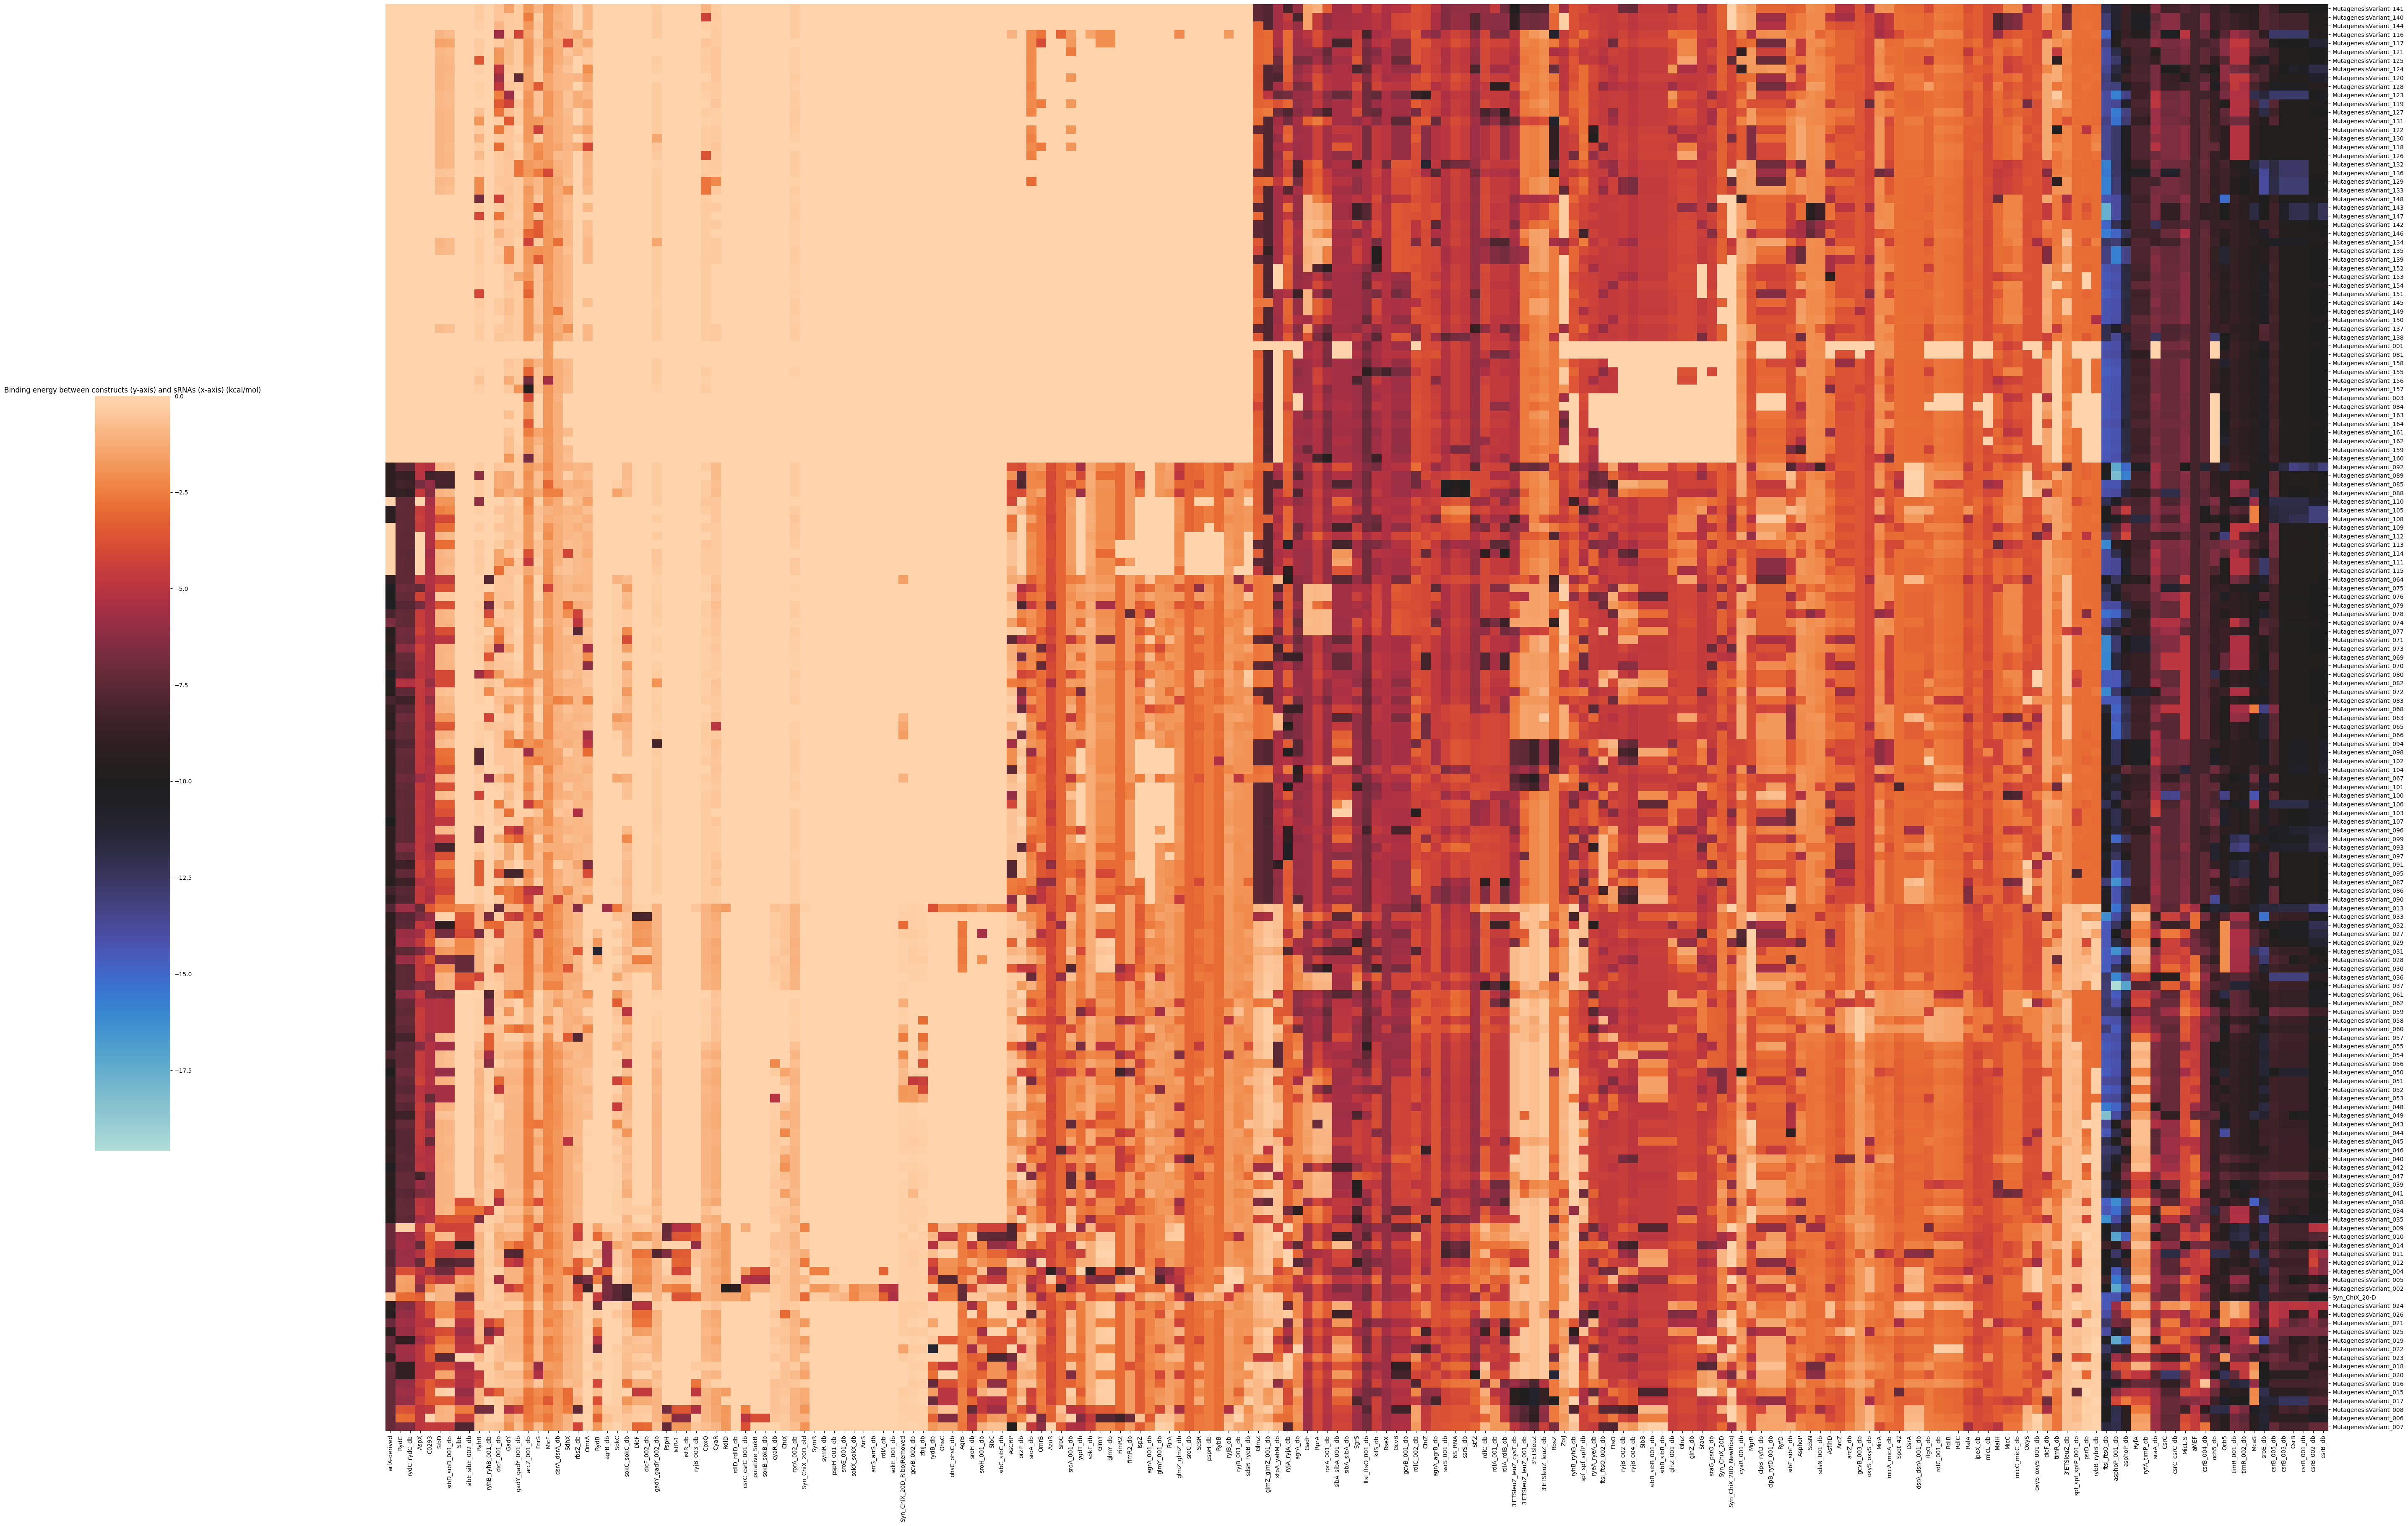

In [146]:
energies_m = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l_muts.values()]).T,
                        columns=sim_data_l_muts.keys(), index=list(list(sim_data_l_muts.values())[0].keys()))
energies_m.index = list(map(lambda x: '_'.join([x.split('_')[0], x.split('_')[1].zfill(3)]) if 'Syn' not in x else x, energies_m.index.to_list()))
energies_m = energies_m.sort_index()[sorted(energies_m.columns, key=lambda x: x.lower())]

ax = sns.clustermap(energies_m, center =-10, row_cluster=True, figsize=(60, 45), cbar_pos=(0.08, .2, .03, .4))
ax.ax_col_dendrogram.set_visible(False)
ax.ax_row_dendrogram.set_visible(False)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')


Text(0.5, 1.0, 'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\n(nan where $\\Delta$G > -10)')

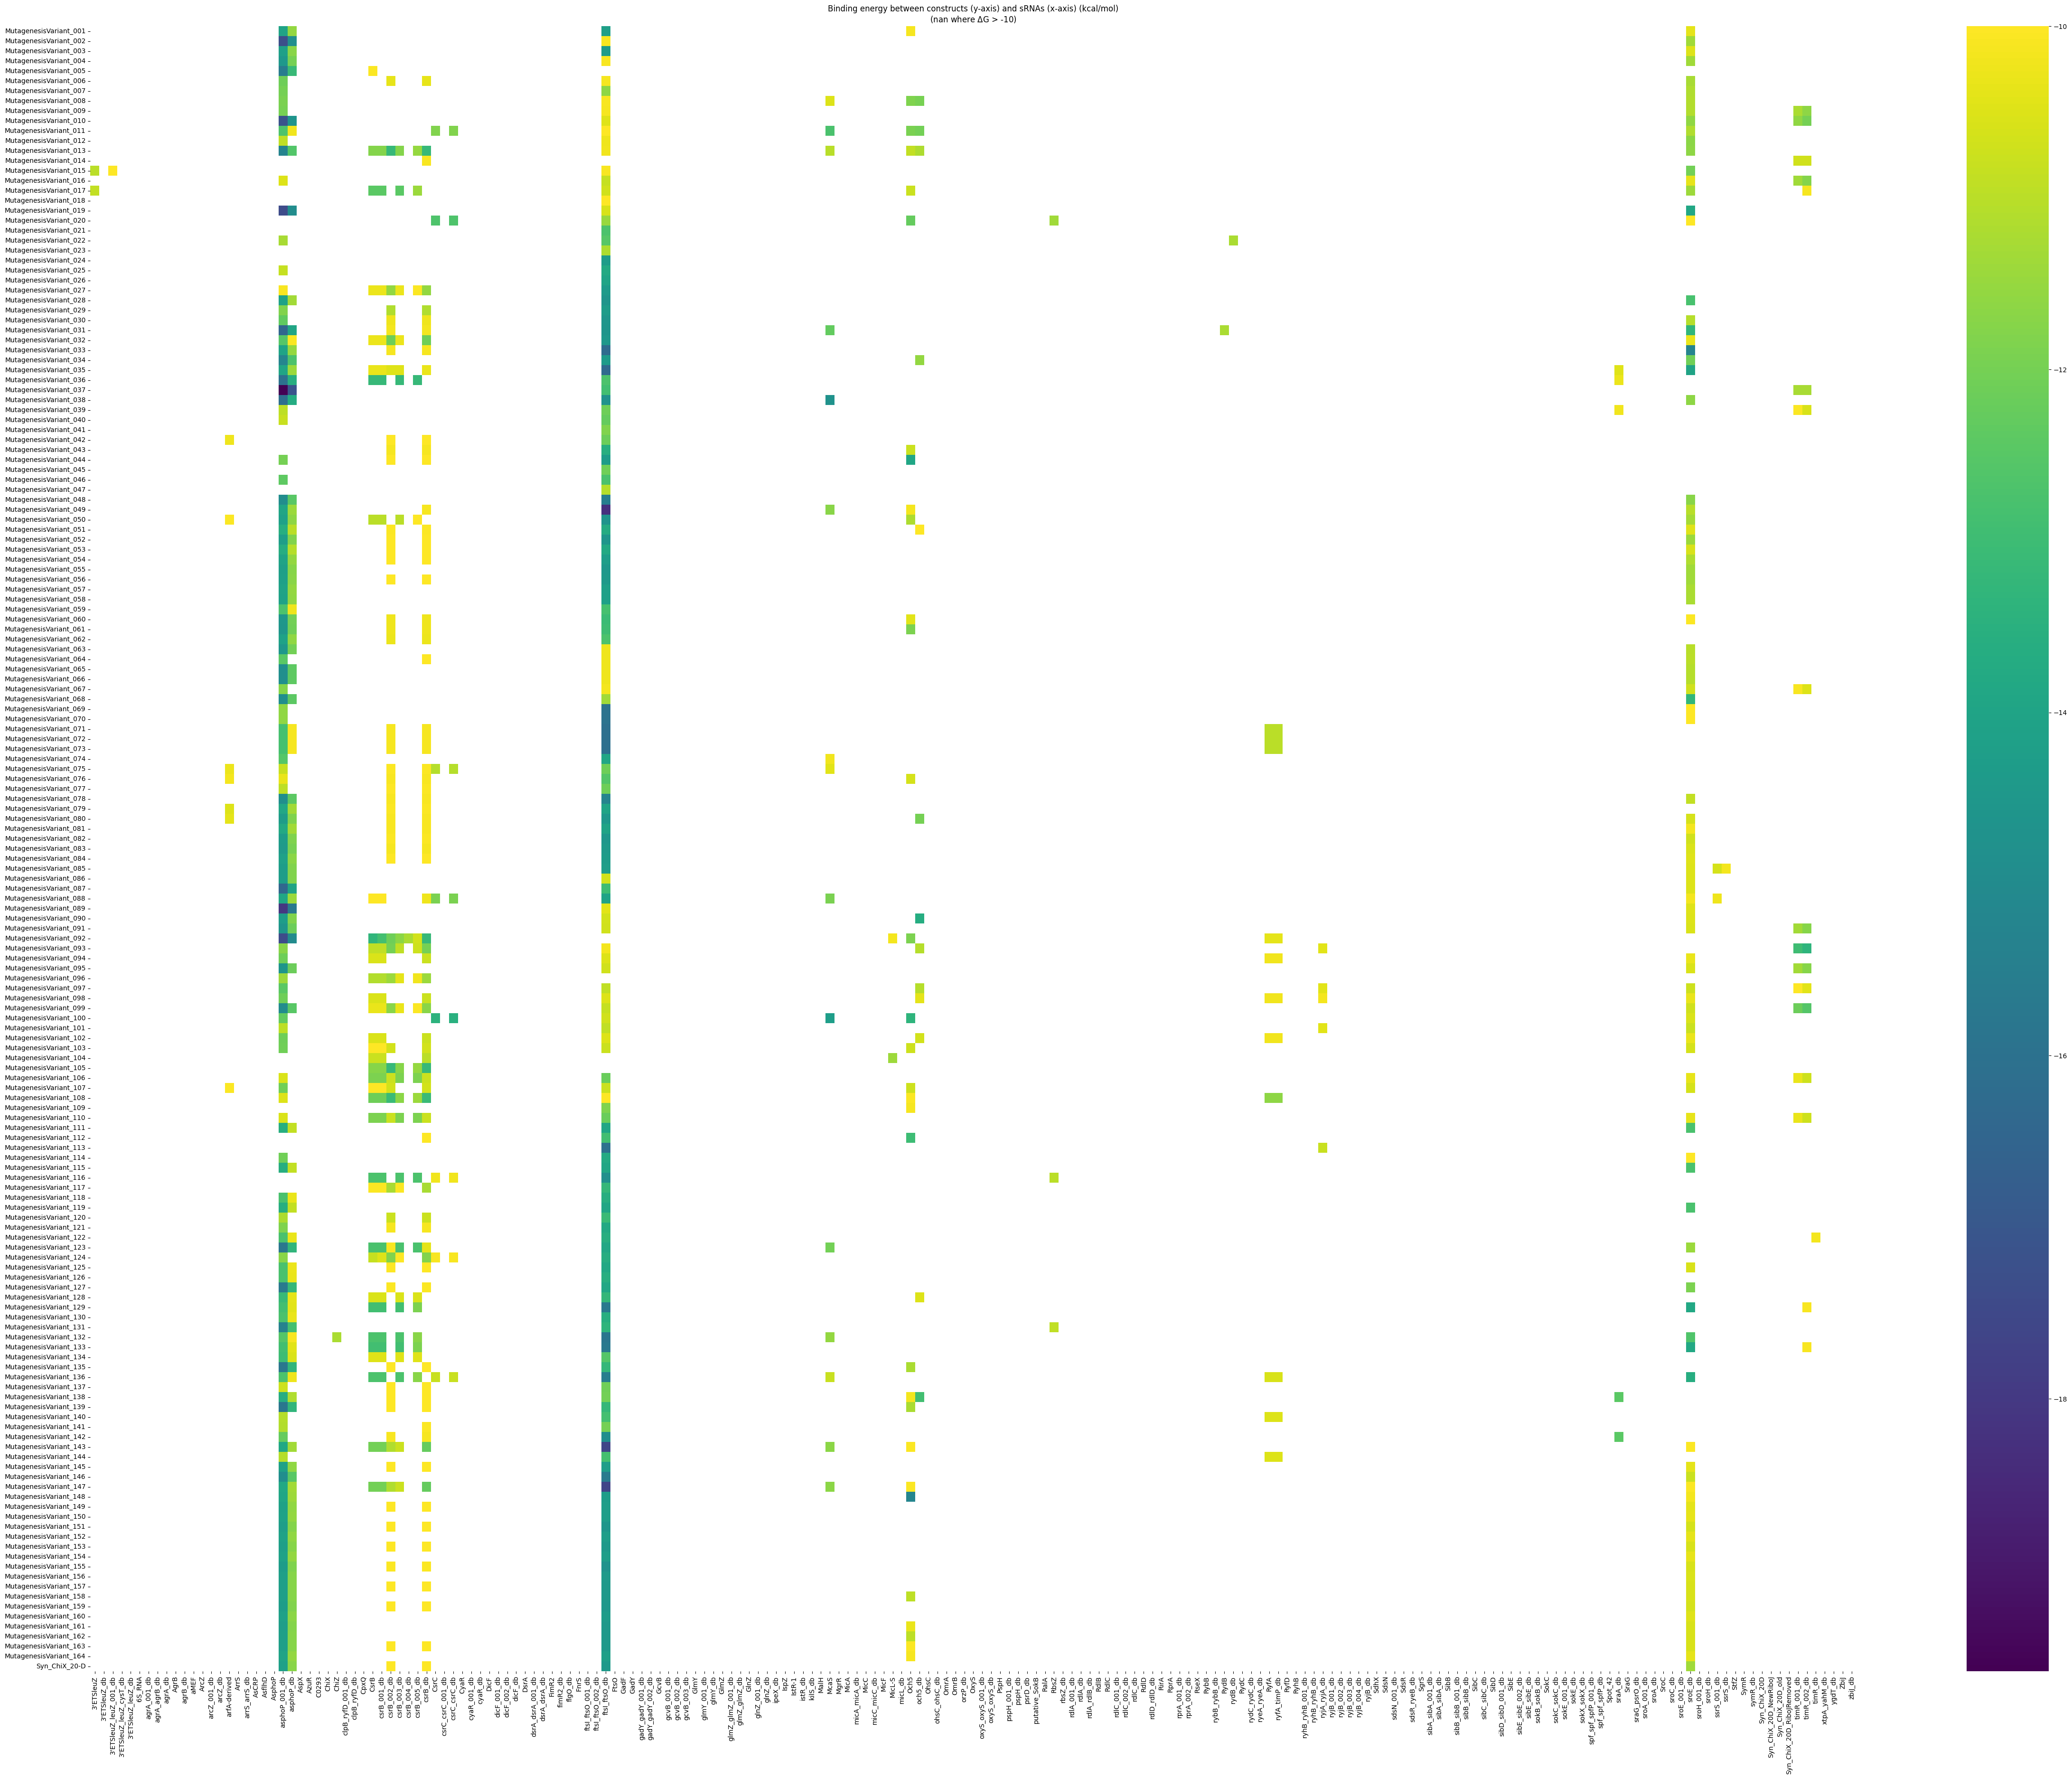

In [147]:
fig = plt.figure(figsize=(60, 45))
fig.subplots_adjust(hspace=0.4)
thresh = -10
energies_m[energies_m > thresh] = np.nan
sns.heatmap(energies_m, cmap='viridis') 
plt.title(f'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\n(nan where $\Delta$G > {thresh})')


## Genome interference

In [148]:
energies_g = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l_geno.values()]),
                        index=sim_data_l_geno.keys(), columns=list(list(sim_data_l_geno.values())[0].keys()))
energies_g = energies_g.sort_index(key=lambda x: x.str.lower())[sorted(energies_g.columns, key=lambda x: x.lower())]


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Binding energy between transcription units\nof DH10B vs. constructs (x-axis)')

<Figure size 7000x2000 with 0 Axes>

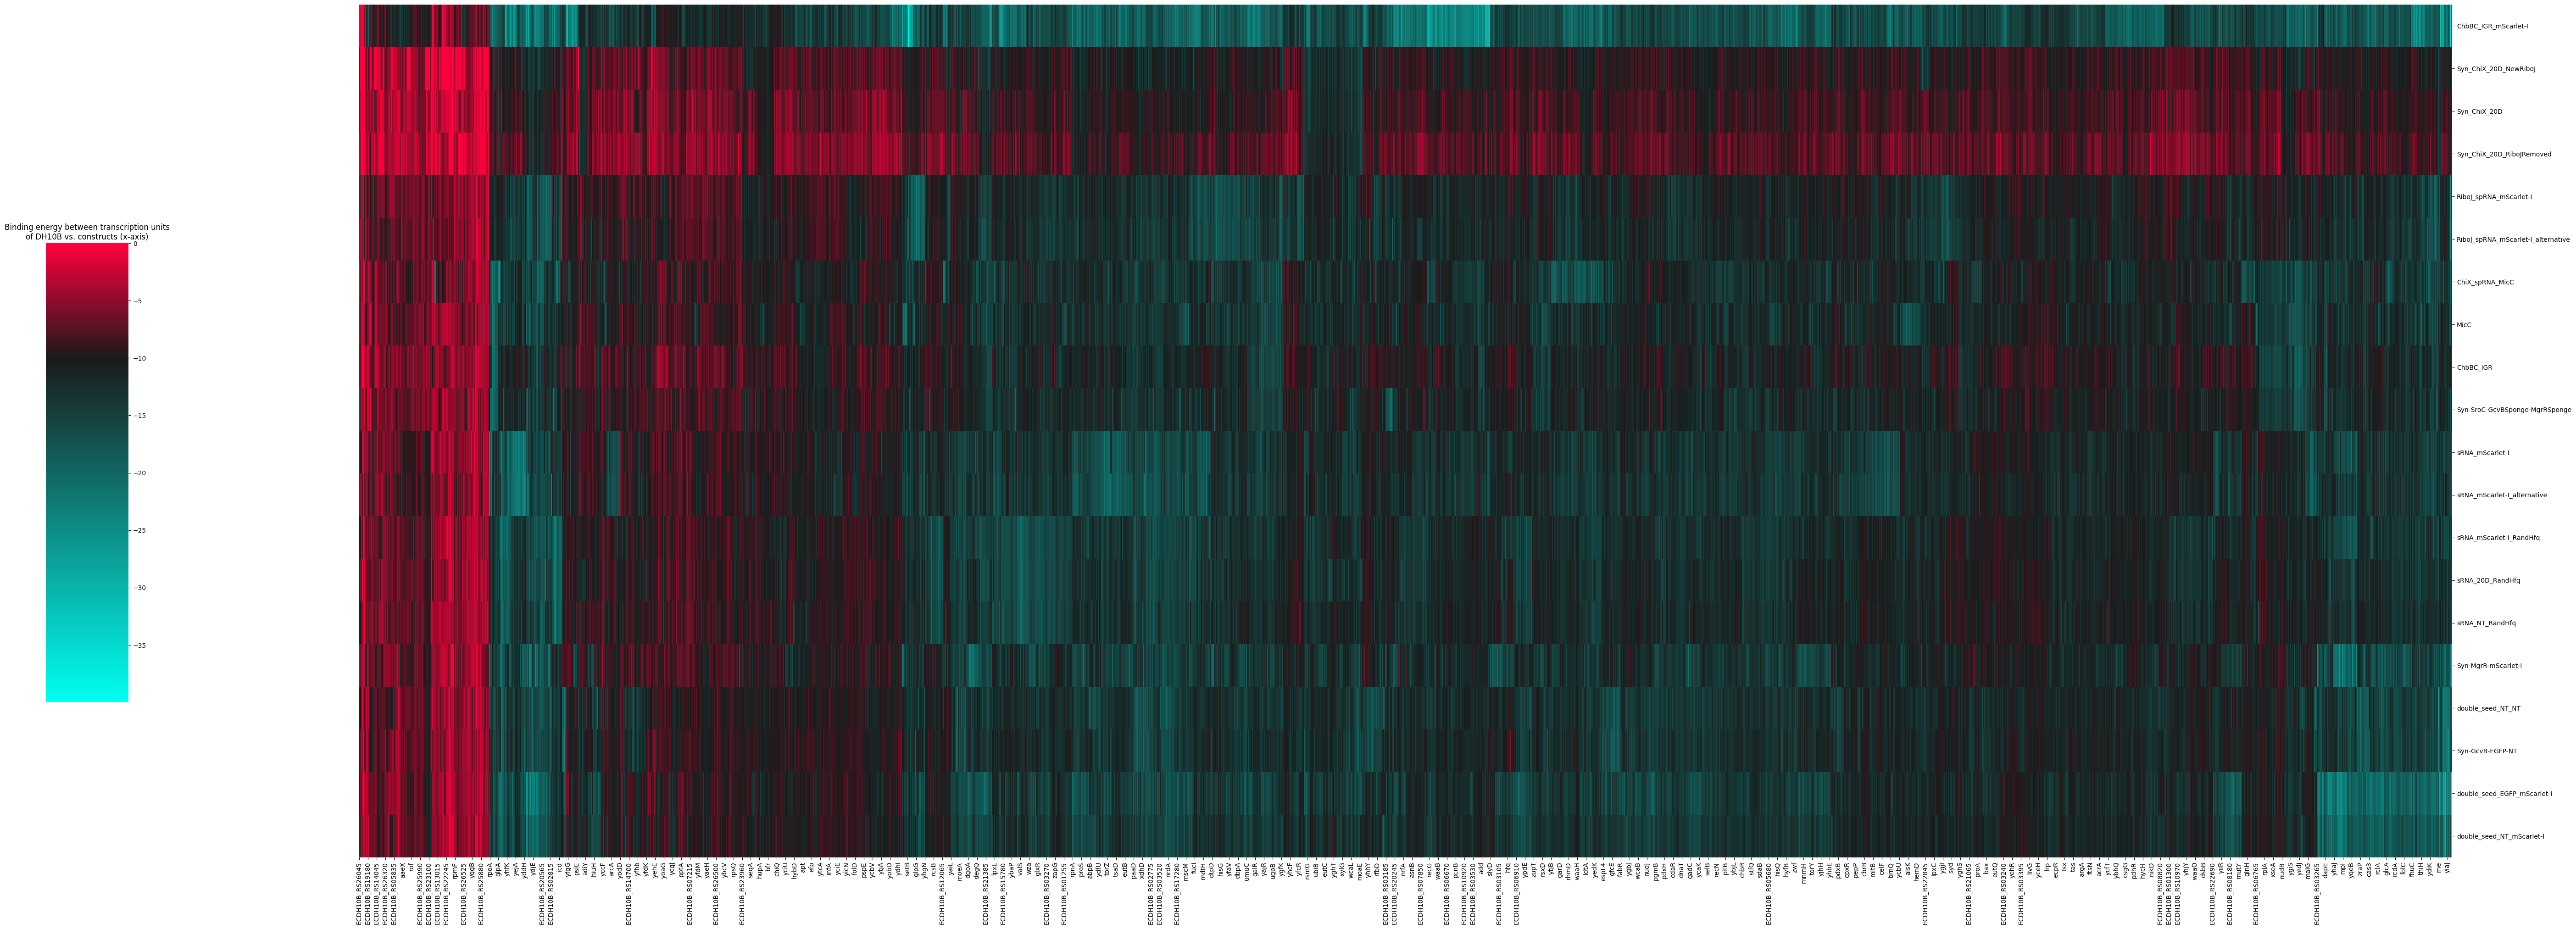

In [155]:
custom_cmap = make_diverging(-energies_g, center=np.max(-energies_g) - 10, 
                             center_color=center_color_d, cool_color='#00fff2')
ax = sns.clustermap(energies_g.T, figsize=(60, 25), cbar_pos=(0.08, .2, .03, .4), cmap=custom_cmap) #center =-10)
ax.ax_col_dendrogram.set_visible(False)
ax.ax_row_dendrogram.set_visible(False)
plt.title('Binding energy between transcription units\nof DH10B vs. constructs (x-axis)')


In [156]:
print('Potential mRNA interference with sponge RNAs or synthetic sRNAs:')
summary = {}
for c in energies_g.columns: 
    summary[c] = energies_g[c][energies_g[c] < -30].to_dict()
    
summary

Potential mRNA interference with sponge RNAs or synthetic sRNAs:


{'ChbBC_IGR': {},
 'ChbBC_IGR_mScarlet-I': {'bcsE': -32.77,
  'copD': -31.93,
  'ECDH10B_RS02885': -30.45,
  'ECDH10B_RS03420': -30.45,
  'ECDH10B_RS08190': -31.83,
  'ECDH10B_RS25830': -35.21,
  'ECDH10B_RS25975': -30.14,
  'eptA': -32.88,
  'fadE': -39.95,
  'hyuA': -32.94,
  'lhr': -32.07,
  'nagE': -33.21,
  'nanS': -33.01,
  'nrfD': -30.67,
  'ssb1': -35.41,
  'ubiE': -30.2,
  'wzxC': -30.36,
  'wzyE': -35.73,
  'yafL': -31.24,
  'ycjR': -31.6,
  'yebQ': -31.67,
  'yeeO': -36.86,
  'yfjQ': -34.92,
  'yneE': -30.62},
 'ChiX_spRNA_MicC': {},
 'double_seed_EGFP_mScarlet-I': {'dcp': -30.33,
  'gsiA': -39.51,
  'ldcC': -31.34,
  'rpnC': -33.03,
  'yfjQ': -30.13,
  'yqeF': -31.65},
 'double_seed_NT_mScarlet-I': {'gsiA': -35.28,
  'ldcC': -31.33,
  'narG': -34.3,
  'yqeF': -30.01},
 'double_seed_NT_NT': {'narG': -34.74},
 'MicC': {},
 'RiboJ_spRNA_mScarlet-I': {},
 'RiboJ_spRNA_mScarlet-I_alternative': {},
 'sRNA_20D_RandHfq': {},
 'sRNA_mScarlet-I': {'rpoA': -31.12},
 'sRNA_mScarlet-I_a

In [158]:
fn_report = os.path.join(top_dir, 'mrna_crosstalk_summary.json')
summary = {}
for c in energies_g.columns: 
    summary[c] = energies_g[c][energies_g[c] < -20].to_dict()
    
from synbio_morpher.utils.data.data_format_tools.common import write_json

write_json(data=summary, out_path=fn_report, overwrite=True)